In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset

from csng.imagenet.models import ResnetExtractor, UpsampleModel, count_parameters



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


# Weight decay


In [2]:
# Define the image limit
BATCH_SIZE = 64

TRAIN_SIZE = 2000 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 5
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=5e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224


class CachedImageNet(ImageNet):
    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet_extractor = None

    def get_extractor(self):
        if self.resnet_extractor is None:
            self.resnet_extractor = ResnetExtractor()
        return self.resnet_extractor

    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path):
            # # Image transformations
            # if os.path.exists(cache_path):
            #     saved_features = torch.load(cache_path).to(device)
            #     assert torch.equal(features,saved_features)

            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imagenet_input = torchvision.transforms.functional.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)
            features = self.get_extractor().get_features(imagenet_input)
            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='1.1'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Train loader contains 2000 batches.
Test loader contains 20 batches.


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


torch.Size([64, 1, 224, 224])


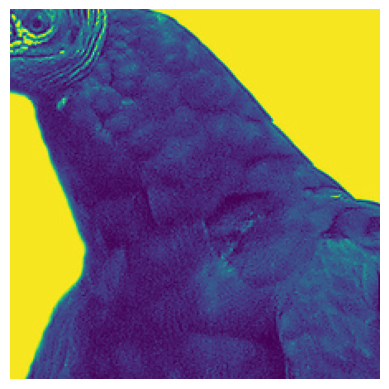

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:


# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in tqdm(enumerate(train_loader)):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


0it [00:00, ?it/s]

1it [00:05,  5.45s/it]

2it [00:09,  4.63s/it]

3it [00:13,  4.23s/it]

4it [00:17,  4.07s/it]

5it [00:21,  4.12s/it]

Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7751


6it [00:25,  4.04s/it]

7it [00:29,  4.04s/it]

8it [00:33,  4.05s/it]

9it [00:37,  3.97s/it]

10it [00:41,  3.97s/it]

Epoch 1, Batch 10, LR: 0.000050, Loss: 0.6403


11it [00:44,  3.94s/it]

12it [00:48,  3.91s/it]

13it [00:52,  3.94s/it]

14it [00:57,  4.19s/it]

15it [01:01,  4.14s/it]

Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6126


16it [01:05,  4.03s/it]

17it [01:09,  3.95s/it]

18it [01:13,  3.97s/it]

19it [01:17,  3.99s/it]

20it [01:21,  4.05s/it]

Epoch 1, Batch 20, LR: 0.000050, Loss: 0.5989


21it [01:25,  4.01s/it]

22it [01:29,  3.94s/it]

23it [01:33,  3.97s/it]

24it [01:36,  3.92s/it]

25it [01:41,  4.01s/it]

Epoch 1, Batch 25, LR: 0.000050, Loss: 0.5938


26it [01:45,  3.98s/it]

27it [01:48,  3.95s/it]

28it [01:53,  4.01s/it]

29it [01:56,  3.95s/it]

30it [02:00,  3.93s/it]

Epoch 1, Batch 30, LR: 0.000050, Loss: 0.5903


31it [02:04,  3.98s/it]

32it [02:08,  4.00s/it]

33it [02:12,  4.00s/it]

34it [02:16,  4.02s/it]

35it [02:20,  4.02s/it]

Epoch 1, Batch 35, LR: 0.000050, Loss: 0.5862


36it [02:24,  3.96s/it]

37it [02:28,  3.92s/it]

38it [02:32,  3.91s/it]

39it [02:36,  4.08s/it]

40it [02:41,  4.08s/it]

Epoch 1, Batch 40, LR: 0.000050, Loss: 0.5896


41it [02:45,  4.08s/it]

42it [02:49,  4.27s/it]

43it [02:53,  4.18s/it]

44it [02:57,  4.07s/it]

45it [03:01,  4.07s/it]

Epoch 1, Batch 45, LR: 0.000050, Loss: 0.5845


46it [03:05,  4.09s/it]

47it [03:09,  4.11s/it]

48it [03:14,  4.19s/it]

49it [03:18,  4.17s/it]

50it [03:22,  4.09s/it]

Epoch 1, Batch 50, LR: 0.000050, Loss: 0.5867


51it [03:26,  4.01s/it]

52it [03:30,  3.98s/it]

53it [03:34,  4.02s/it]

54it [03:39,  4.25s/it]

55it [03:42,  4.11s/it]

Epoch 1, Batch 55, LR: 0.000050, Loss: 0.5886


56it [03:46,  4.04s/it]

57it [03:50,  4.02s/it]

58it [03:54,  3.99s/it]

59it [03:58,  3.93s/it]

60it [04:02,  3.90s/it]

Epoch 1, Batch 60, LR: 0.000050, Loss: 0.5869


61it [04:06,  3.88s/it]

62it [04:09,  3.85s/it]

63it [04:13,  3.92s/it]

64it [04:17,  3.88s/it]

65it [04:21,  3.85s/it]

Epoch 1, Batch 65, LR: 0.000050, Loss: 0.5834


66it [04:25,  3.90s/it]

67it [04:29,  4.05s/it]

68it [04:33,  4.00s/it]

69it [04:37,  3.98s/it]

70it [04:41,  3.98s/it]

Epoch 1, Batch 70, LR: 0.000050, Loss: 0.5841


71it [04:45,  3.92s/it]

72it [04:49,  4.04s/it]

73it [04:53,  4.01s/it]

74it [04:57,  4.00s/it]

75it [05:01,  3.97s/it]

Epoch 1, Batch 75, LR: 0.000050, Loss: 0.5863


76it [05:05,  3.94s/it]

77it [05:09,  3.93s/it]

78it [05:13,  3.94s/it]

79it [05:17,  3.97s/it]

80it [05:21,  3.97s/it]

Epoch 1, Batch 80, LR: 0.000050, Loss: 0.5845


81it [05:25,  3.96s/it]

82it [05:29,  3.90s/it]

83it [05:33,  4.08s/it]

84it [05:37,  4.12s/it]

85it [05:41,  4.12s/it]

Epoch 1, Batch 85, LR: 0.000050, Loss: 0.5787


86it [05:46,  4.15s/it]

87it [05:50,  4.10s/it]

88it [05:54,  4.07s/it]

89it [05:57,  4.02s/it]

90it [06:01,  3.99s/it]

Epoch 1, Batch 90, LR: 0.000050, Loss: 0.5813


91it [06:05,  3.95s/it]

92it [06:09,  3.90s/it]

93it [06:13,  3.94s/it]

94it [06:17,  3.97s/it]

95it [06:21,  3.89s/it]

Epoch 1, Batch 95, LR: 0.000050, Loss: 0.5770


96it [06:25,  3.85s/it]

97it [06:28,  3.83s/it]

98it [06:32,  3.85s/it]

99it [06:36,  3.88s/it]

100it [06:40,  3.90s/it]

Epoch 1, Batch 100, LR: 0.000050, Loss: 0.5789


101it [06:44,  3.86s/it]

102it [06:48,  3.88s/it]

103it [06:52,  3.88s/it]

104it [06:56,  3.90s/it]

105it [07:00,  3.91s/it]

Epoch 1, Batch 105, LR: 0.000050, Loss: 0.5748


106it [07:04,  3.92s/it]

107it [07:08,  3.98s/it]

108it [07:12,  4.00s/it]

109it [07:16,  3.97s/it]

110it [07:19,  3.94s/it]

Epoch 1, Batch 110, LR: 0.000050, Loss: 0.5667


111it [07:23,  3.91s/it]

112it [07:27,  3.87s/it]

113it [07:31,  3.84s/it]

114it [07:35,  3.90s/it]

115it [07:39,  3.85s/it]

Epoch 1, Batch 115, LR: 0.000050, Loss: 0.5758


116it [07:43,  3.86s/it]

117it [07:46,  3.83s/it]

118it [07:53,  4.56s/it]

119it [07:56,  4.31s/it]

120it [08:00,  4.16s/it]

Epoch 1, Batch 120, LR: 0.000050, Loss: 0.5773


121it [08:04,  4.08s/it]

122it [08:08,  4.01s/it]

123it [08:12,  4.03s/it]

124it [08:16,  4.01s/it]

125it [08:20,  4.07s/it]

Epoch 1, Batch 125, LR: 0.000050, Loss: 0.5795


126it [08:24,  4.09s/it]

127it [08:28,  4.05s/it]

128it [08:32,  3.97s/it]

129it [08:36,  3.96s/it]

130it [08:40,  4.02s/it]

Epoch 1, Batch 130, LR: 0.000049, Loss: 0.5819


131it [08:44,  3.97s/it]

132it [08:48,  3.99s/it]

133it [08:52,  3.99s/it]

134it [08:56,  3.93s/it]

135it [09:00,  4.03s/it]

Epoch 1, Batch 135, LR: 0.000049, Loss: 0.5854


136it [09:04,  4.06s/it]

137it [09:08,  4.14s/it]

138it [09:12,  4.07s/it]

139it [09:16,  4.04s/it]

140it [09:20,  4.02s/it]

Epoch 1, Batch 140, LR: 0.000049, Loss: 0.5757


141it [09:25,  4.11s/it]

142it [09:29,  4.07s/it]

143it [09:33,  4.06s/it]

144it [09:37,  4.04s/it]

145it [09:41,  4.03s/it]

Epoch 1, Batch 145, LR: 0.000049, Loss: 0.5769


146it [09:45,  4.06s/it]

147it [09:49,  4.16s/it]

148it [09:53,  4.17s/it]

149it [09:58,  4.23s/it]

150it [10:03,  4.42s/it]

Epoch 1, Batch 150, LR: 0.000049, Loss: 0.5875


151it [10:07,  4.33s/it]

152it [10:11,  4.22s/it]

153it [10:16,  4.61s/it]

154it [10:20,  4.44s/it]

155it [10:24,  4.27s/it]

Epoch 1, Batch 155, LR: 0.000049, Loss: 0.5744


156it [10:28,  4.15s/it]

157it [10:32,  4.14s/it]

158it [10:36,  4.08s/it]

159it [10:40,  4.11s/it]

160it [10:45,  4.25s/it]

Epoch 1, Batch 160, LR: 0.000049, Loss: 0.5785


161it [10:49,  4.21s/it]

162it [10:53,  4.11s/it]

163it [10:57,  4.13s/it]

164it [11:01,  4.01s/it]

165it [11:05,  4.00s/it]

Epoch 1, Batch 165, LR: 0.000049, Loss: 0.5675


166it [11:08,  3.96s/it]

167it [11:12,  3.94s/it]

168it [11:16,  3.94s/it]

169it [11:20,  3.92s/it]

170it [11:24,  3.88s/it]

Epoch 1, Batch 170, LR: 0.000049, Loss: 0.5780


171it [11:28,  3.99s/it]

172it [11:32,  3.97s/it]

173it [11:37,  4.11s/it]

174it [11:40,  4.05s/it]

175it [11:44,  4.00s/it]

Epoch 1, Batch 175, LR: 0.000049, Loss: 0.5758


176it [11:48,  4.02s/it]

177it [11:52,  3.98s/it]

178it [11:56,  3.93s/it]

179it [12:00,  3.90s/it]

180it [12:04,  4.05s/it]

Epoch 1, Batch 180, LR: 0.000049, Loss: 0.5820


181it [12:08,  4.00s/it]

182it [12:12,  3.97s/it]

183it [12:16,  3.97s/it]

184it [12:20,  3.97s/it]

185it [12:24,  4.04s/it]

Epoch 1, Batch 185, LR: 0.000049, Loss: 0.5812


186it [12:28,  4.00s/it]

187it [12:32,  3.97s/it]

188it [12:36,  4.05s/it]

189it [12:40,  4.06s/it]

190it [12:44,  4.07s/it]

Epoch 1, Batch 190, LR: 0.000049, Loss: 0.5785


191it [12:48,  4.05s/it]

192it [12:52,  4.02s/it]

193it [12:56,  4.01s/it]

194it [13:00,  3.96s/it]

195it [13:04,  3.94s/it]

Epoch 1, Batch 195, LR: 0.000049, Loss: 0.5715


196it [13:08,  3.96s/it]

197it [13:12,  3.99s/it]

198it [13:16,  3.97s/it]

199it [13:20,  4.06s/it]

200it [13:25,  4.07s/it]

Epoch 1, Batch 200, LR: 0.000049, Loss: 0.5763


201it [13:29,  4.07s/it]

202it [13:33,  4.05s/it]

203it [13:36,  3.99s/it]

204it [13:40,  4.00s/it]

205it [13:44,  3.98s/it]

Epoch 1, Batch 205, LR: 0.000049, Loss: 0.5734


206it [13:49,  4.05s/it]

207it [13:53,  4.10s/it]

208it [13:57,  4.08s/it]

209it [14:01,  4.12s/it]

210it [14:06,  4.28s/it]

Epoch 1, Batch 210, LR: 0.000049, Loss: 0.5743


211it [14:10,  4.29s/it]

212it [14:14,  4.24s/it]

213it [14:18,  4.13s/it]

214it [14:22,  4.22s/it]

215it [14:27,  4.16s/it]

Epoch 1, Batch 215, LR: 0.000049, Loss: 0.5781


216it [14:31,  4.12s/it]

217it [14:35,  4.13s/it]

218it [14:39,  4.10s/it]

219it [14:43,  4.10s/it]

220it [14:47,  4.14s/it]

Epoch 1, Batch 220, LR: 0.000049, Loss: 0.5767


221it [14:51,  4.13s/it]

222it [14:55,  4.14s/it]

223it [14:59,  4.13s/it]

224it [15:03,  4.09s/it]

225it [15:07,  4.07s/it]

Epoch 1, Batch 225, LR: 0.000048, Loss: 0.5775


226it [15:11,  4.05s/it]

227it [15:15,  3.99s/it]

228it [15:19,  3.95s/it]

229it [15:23,  3.96s/it]

230it [15:27,  3.98s/it]

Epoch 1, Batch 230, LR: 0.000048, Loss: 0.5791


231it [15:32,  4.21s/it]

232it [15:36,  4.14s/it]

233it [15:40,  4.20s/it]

234it [15:44,  4.19s/it]

235it [15:48,  4.15s/it]

Epoch 1, Batch 235, LR: 0.000048, Loss: 0.5710


236it [15:52,  4.11s/it]

237it [15:56,  4.02s/it]

238it [16:00,  4.00s/it]

239it [16:04,  3.97s/it]

240it [16:08,  4.06s/it]

Epoch 1, Batch 240, LR: 0.000048, Loss: 0.5780


241it [16:12,  4.00s/it]

242it [16:16,  3.99s/it]

243it [16:20,  4.01s/it]

244it [16:24,  3.98s/it]

245it [16:28,  3.98s/it]

Epoch 1, Batch 245, LR: 0.000048, Loss: 0.5755


246it [16:32,  3.95s/it]

247it [16:36,  3.97s/it]

248it [16:40,  3.95s/it]

249it [16:44,  3.91s/it]

250it [16:48,  3.89s/it]

Epoch 1, Batch 250, LR: 0.000048, Loss: 0.5666


251it [16:53,  4.40s/it]

252it [16:57,  4.25s/it]

253it [17:08,  6.12s/it]

254it [17:12,  5.47s/it]

255it [17:16,  5.06s/it]

Epoch 1, Batch 255, LR: 0.000048, Loss: 0.5786


256it [17:20,  4.70s/it]

257it [17:23,  4.42s/it]

258it [17:27,  4.29s/it]

259it [17:31,  4.15s/it]

260it [17:35,  4.11s/it]

Epoch 1, Batch 260, LR: 0.000048, Loss: 0.5730


261it [17:39,  4.05s/it]

262it [17:43,  3.99s/it]

263it [17:47,  3.94s/it]

264it [17:51,  3.96s/it]

265it [17:55,  3.93s/it]

Epoch 1, Batch 265, LR: 0.000048, Loss: 0.5730


266it [17:59,  3.97s/it]

267it [18:03,  3.99s/it]

268it [18:14,  6.28s/it]

269it [18:19,  5.66s/it]

270it [18:23,  5.19s/it]

Epoch 1, Batch 270, LR: 0.000048, Loss: 0.5739


271it [18:27,  4.82s/it]

272it [18:30,  4.53s/it]

273it [18:34,  4.29s/it]

274it [18:39,  4.40s/it]

275it [18:43,  4.29s/it]

Epoch 1, Batch 275, LR: 0.000048, Loss: 0.5784


276it [18:47,  4.28s/it]

277it [18:51,  4.19s/it]

278it [18:55,  4.10s/it]

279it [18:59,  4.06s/it]

280it [19:03,  4.10s/it]

Epoch 1, Batch 280, LR: 0.000048, Loss: 0.5717


281it [19:07,  4.09s/it]

282it [19:11,  4.10s/it]

283it [19:15,  4.06s/it]

284it [19:19,  4.09s/it]

285it [19:23,  4.05s/it]

Epoch 1, Batch 285, LR: 0.000048, Loss: 0.5771


286it [19:27,  3.97s/it]

287it [19:31,  3.95s/it]

288it [19:35,  3.92s/it]

289it [19:39,  3.91s/it]

290it [19:43,  3.86s/it]

Epoch 1, Batch 290, LR: 0.000047, Loss: 0.5744


291it [19:48,  4.36s/it]

292it [19:52,  4.18s/it]

293it [19:56,  4.09s/it]

294it [20:00,  4.19s/it]

295it [20:04,  4.04s/it]

Epoch 1, Batch 295, LR: 0.000047, Loss: 0.5721


296it [20:08,  3.94s/it]

297it [20:11,  3.89s/it]

298it [20:15,  3.84s/it]

299it [20:19,  3.81s/it]

300it [20:23,  3.81s/it]

Epoch 1, Batch 300, LR: 0.000047, Loss: 0.5723


301it [20:26,  3.79s/it]

302it [20:30,  3.79s/it]

303it [20:34,  3.82s/it]

304it [20:38,  3.80s/it]

305it [20:41,  3.73s/it]

Epoch 1, Batch 305, LR: 0.000047, Loss: 0.5761


306it [20:45,  3.70s/it]

307it [20:49,  3.76s/it]

308it [20:53,  3.81s/it]

309it [20:57,  3.87s/it]

310it [21:04,  4.81s/it]

Epoch 1, Batch 310, LR: 0.000047, Loss: 0.5817


311it [21:08,  4.48s/it]

312it [21:11,  4.28s/it]

313it [21:15,  4.11s/it]

314it [21:19,  4.00s/it]

315it [21:23,  3.97s/it]

Epoch 1, Batch 315, LR: 0.000047, Loss: 0.5755


316it [21:26,  3.91s/it]

317it [21:30,  3.90s/it]

318it [21:35,  4.03s/it]

319it [21:39,  4.19s/it]

320it [21:43,  4.06s/it]

Epoch 1, Batch 320, LR: 0.000047, Loss: 0.5753


321it [21:47,  4.07s/it]

322it [21:52,  4.23s/it]

323it [21:56,  4.20s/it]

324it [22:00,  4.09s/it]

325it [22:04,  4.06s/it]

Epoch 1, Batch 325, LR: 0.000047, Loss: 0.5780


326it [22:08,  4.02s/it]

327it [22:12,  4.02s/it]

328it [22:16,  4.00s/it]

329it [22:20,  4.01s/it]

330it [22:24,  4.03s/it]

Epoch 1, Batch 330, LR: 0.000047, Loss: 0.5782


331it [22:28,  3.98s/it]

332it [22:32,  4.03s/it]

333it [22:36,  4.04s/it]

334it [22:40,  4.05s/it]

335it [22:44,  4.04s/it]

Epoch 1, Batch 335, LR: 0.000047, Loss: 0.5747


336it [22:48,  4.01s/it]

337it [22:52,  3.96s/it]

338it [22:55,  3.93s/it]

339it [23:00,  3.97s/it]

340it [23:04,  4.00s/it]

Epoch 1, Batch 340, LR: 0.000047, Loss: 0.5698


341it [23:08,  4.25s/it]

342it [23:12,  4.14s/it]

343it [23:16,  4.13s/it]

344it [23:20,  4.05s/it]

345it [23:25,  4.30s/it]

Epoch 1, Batch 345, LR: 0.000046, Loss: 0.5698


346it [23:29,  4.23s/it]

347it [23:33,  4.19s/it]

348it [23:38,  4.25s/it]

349it [23:42,  4.20s/it]

350it [23:46,  4.14s/it]

Epoch 1, Batch 350, LR: 0.000046, Loss: 0.5757


351it [23:50,  4.09s/it]

352it [23:54,  4.18s/it]

353it [23:58,  4.13s/it]

354it [24:02,  4.07s/it]

355it [24:06,  4.01s/it]

Epoch 1, Batch 355, LR: 0.000046, Loss: 0.5788


356it [24:10,  4.00s/it]

357it [24:14,  4.03s/it]

358it [24:18,  4.01s/it]

359it [24:22,  3.99s/it]

360it [24:26,  4.01s/it]

Epoch 1, Batch 360, LR: 0.000046, Loss: 0.5821


361it [24:30,  3.97s/it]

362it [24:34,  4.04s/it]

363it [24:39,  4.23s/it]

364it [24:43,  4.21s/it]

365it [24:47,  4.12s/it]

Epoch 1, Batch 365, LR: 0.000046, Loss: 0.5789


366it [24:51,  4.09s/it]

367it [24:55,  4.02s/it]

368it [24:59,  4.06s/it]

369it [25:03,  4.02s/it]

370it [25:07,  4.03s/it]

Epoch 1, Batch 370, LR: 0.000046, Loss: 0.5709


371it [25:11,  4.01s/it]

372it [25:15,  3.99s/it]

373it [25:18,  3.91s/it]

374it [25:23,  3.99s/it]

375it [25:27,  4.06s/it]

Epoch 1, Batch 375, LR: 0.000046, Loss: 0.5731


376it [25:31,  4.05s/it]

377it [25:35,  4.02s/it]

378it [25:39,  4.06s/it]

379it [25:43,  4.04s/it]

380it [25:47,  4.02s/it]

Epoch 1, Batch 380, LR: 0.000046, Loss: 0.5703


381it [25:51,  4.03s/it]

382it [25:55,  4.12s/it]

383it [25:59,  4.10s/it]

384it [26:03,  4.08s/it]

385it [26:07,  4.04s/it]

Epoch 1, Batch 385, LR: 0.000046, Loss: 0.5738


386it [26:12,  4.11s/it]

387it [26:16,  4.06s/it]

388it [26:20,  4.22s/it]

389it [26:25,  4.24s/it]

390it [26:29,  4.17s/it]

Epoch 1, Batch 390, LR: 0.000045, Loss: 0.5816


391it [26:32,  4.08s/it]

392it [26:36,  3.98s/it]

393it [26:40,  4.00s/it]

394it [26:44,  4.01s/it]

395it [26:48,  3.94s/it]

Epoch 1, Batch 395, LR: 0.000045, Loss: 0.5686


396it [26:52,  3.98s/it]

397it [26:56,  4.00s/it]

398it [27:00,  4.01s/it]

399it [27:04,  3.97s/it]

400it [27:08,  3.96s/it]

Epoch 1, Batch 400, LR: 0.000045, Loss: 0.5726


401it [27:12,  3.90s/it]

402it [27:16,  4.10s/it]

403it [27:20,  4.05s/it]

404it [27:24,  4.05s/it]

405it [27:28,  4.01s/it]

Epoch 1, Batch 405, LR: 0.000045, Loss: 0.5683


406it [27:32,  4.04s/it]

407it [27:36,  4.00s/it]

408it [27:40,  4.03s/it]

409it [27:44,  3.99s/it]

410it [27:48,  3.96s/it]

Epoch 1, Batch 410, LR: 0.000045, Loss: 0.5686


411it [27:52,  4.04s/it]

412it [27:56,  4.02s/it]

413it [28:00,  3.98s/it]

414it [28:04,  4.02s/it]

415it [28:08,  3.97s/it]

Epoch 1, Batch 415, LR: 0.000045, Loss: 0.5749


416it [28:13,  4.19s/it]

417it [28:17,  4.19s/it]

418it [28:21,  4.20s/it]

419it [28:25,  4.18s/it]

420it [28:30,  4.38s/it]

Epoch 1, Batch 420, LR: 0.000045, Loss: 0.5691


421it [28:34,  4.24s/it]

422it [28:38,  4.21s/it]

423it [28:44,  4.65s/it]

424it [28:48,  4.42s/it]

425it [28:52,  4.32s/it]

Epoch 1, Batch 425, LR: 0.000045, Loss: 0.5825


426it [28:56,  4.27s/it]

427it [29:01,  4.40s/it]

428it [29:05,  4.28s/it]

429it [29:09,  4.25s/it]

430it [29:13,  4.21s/it]

Epoch 1, Batch 430, LR: 0.000045, Loss: 0.5687


431it [29:17,  4.16s/it]

432it [29:21,  4.09s/it]

433it [29:25,  4.14s/it]

434it [29:30,  4.19s/it]

435it [29:34,  4.20s/it]

Epoch 1, Batch 435, LR: 0.000044, Loss: 0.5712


436it [29:38,  4.11s/it]

437it [29:42,  4.21s/it]

438it [29:46,  4.13s/it]

439it [29:50,  4.06s/it]

440it [29:54,  3.99s/it]

Epoch 1, Batch 440, LR: 0.000044, Loss: 0.5715


441it [29:58,  3.97s/it]

442it [30:02,  3.98s/it]

443it [30:06,  3.92s/it]

444it [30:10,  3.95s/it]

445it [30:13,  3.92s/it]

Epoch 1, Batch 445, LR: 0.000044, Loss: 0.5704


446it [30:17,  3.96s/it]

447it [30:21,  3.95s/it]

448it [30:25,  3.99s/it]

449it [30:29,  3.95s/it]

450it [30:33,  3.93s/it]

Epoch 1, Batch 450, LR: 0.000044, Loss: 0.5721


451it [30:38,  4.13s/it]

452it [30:42,  4.07s/it]

453it [30:46,  4.04s/it]

454it [30:50,  4.01s/it]

455it [30:54,  3.99s/it]

Epoch 1, Batch 455, LR: 0.000044, Loss: 0.5742


456it [30:57,  3.94s/it]

457it [31:01,  3.93s/it]

458it [31:05,  3.95s/it]

459it [31:09,  3.96s/it]

460it [31:14,  4.08s/it]

Epoch 1, Batch 460, LR: 0.000044, Loss: 0.5741


461it [31:18,  4.00s/it]

462it [31:22,  4.01s/it]

463it [31:26,  4.03s/it]

464it [31:30,  3.99s/it]

465it [31:34,  4.03s/it]

Epoch 1, Batch 465, LR: 0.000044, Loss: 0.5700


466it [31:37,  3.98s/it]

467it [31:42,  4.01s/it]

468it [31:46,  3.99s/it]

469it [31:50,  4.01s/it]

470it [31:54,  4.01s/it]

Epoch 1, Batch 470, LR: 0.000043, Loss: 0.5689


471it [31:58,  3.98s/it]

472it [32:01,  3.96s/it]

473it [32:06,  4.07s/it]

474it [32:10,  4.01s/it]

475it [32:14,  4.13s/it]

Epoch 1, Batch 475, LR: 0.000043, Loss: 0.5663


476it [32:18,  4.08s/it]

477it [32:22,  4.21s/it]

478it [32:27,  4.23s/it]

479it [32:31,  4.11s/it]

480it [32:34,  4.04s/it]

Epoch 1, Batch 480, LR: 0.000043, Loss: 0.5733


481it [32:38,  4.01s/it]

482it [32:42,  3.99s/it]

483it [32:46,  3.96s/it]

484it [32:50,  3.92s/it]

485it [32:54,  4.01s/it]

Epoch 1, Batch 485, LR: 0.000043, Loss: 0.5705


486it [32:58,  4.01s/it]

487it [33:02,  4.00s/it]

488it [33:06,  3.93s/it]

489it [33:10,  3.93s/it]

490it [33:14,  3.96s/it]

Epoch 1, Batch 490, LR: 0.000043, Loss: 0.5627


491it [33:18,  3.96s/it]

492it [33:22,  3.99s/it]

493it [33:26,  4.03s/it]

494it [33:30,  4.00s/it]

495it [33:34,  4.02s/it]

Epoch 1, Batch 495, LR: 0.000043, Loss: 0.5704


496it [33:38,  4.10s/it]

497it [33:42,  4.03s/it]

498it [33:46,  4.02s/it]

499it [33:54,  5.07s/it]

500it [33:58,  4.74s/it]

Epoch 1, Batch 500, LR: 0.000043, Loss: 0.5663


501it [34:02,  4.48s/it]

502it [34:06,  4.33s/it]

503it [34:10,  4.19s/it]

504it [34:14,  4.12s/it]

505it [34:18,  4.14s/it]

Epoch 1, Batch 505, LR: 0.000043, Loss: 0.5774


506it [34:22,  4.20s/it]

507it [34:26,  4.11s/it]

508it [34:30,  4.08s/it]

509it [34:34,  4.02s/it]

510it [34:38,  3.96s/it]

Epoch 1, Batch 510, LR: 0.000042, Loss: 0.5740


511it [34:42,  3.95s/it]

512it [34:45,  3.92s/it]

513it [34:49,  3.92s/it]

514it [34:53,  3.92s/it]

515it [34:57,  3.91s/it]

Epoch 1, Batch 515, LR: 0.000042, Loss: 0.5777


516it [35:01,  3.98s/it]

517it [35:05,  3.96s/it]

518it [35:09,  3.94s/it]

519it [35:13,  3.86s/it]

520it [35:16,  3.82s/it]

Epoch 1, Batch 520, LR: 0.000042, Loss: 0.5698


521it [35:21,  3.90s/it]

522it [35:25,  3.94s/it]

523it [35:29,  3.96s/it]

524it [35:33,  3.97s/it]

525it [35:37,  3.95s/it]

Epoch 1, Batch 525, LR: 0.000042, Loss: 0.5678


526it [35:40,  3.91s/it]

527it [35:44,  3.92s/it]

528it [35:48,  3.96s/it]

529it [35:52,  3.93s/it]

530it [35:56,  3.89s/it]

Epoch 1, Batch 530, LR: 0.000042, Loss: 0.5698


531it [36:00,  3.91s/it]

532it [36:04,  3.95s/it]

533it [36:08,  4.01s/it]

534it [36:12,  3.96s/it]

535it [36:16,  3.91s/it]

Epoch 1, Batch 535, LR: 0.000042, Loss: 0.5749


536it [36:20,  3.87s/it]

537it [36:24,  4.00s/it]

538it [36:28,  3.95s/it]

539it [36:31,  3.89s/it]

540it [36:35,  3.85s/it]

Epoch 1, Batch 540, LR: 0.000042, Loss: 0.5749


541it [36:39,  3.83s/it]

542it [36:43,  3.82s/it]

543it [36:47,  3.87s/it]

544it [36:51,  3.99s/it]

545it [36:55,  3.99s/it]

Epoch 1, Batch 545, LR: 0.000041, Loss: 0.5737


546it [36:59,  3.94s/it]

547it [37:03,  3.90s/it]

548it [37:07,  3.98s/it]

549it [37:11,  3.92s/it]

550it [37:15,  3.94s/it]

Epoch 1, Batch 550, LR: 0.000041, Loss: 0.5741


551it [37:19,  3.97s/it]

552it [37:22,  3.94s/it]

553it [37:26,  3.94s/it]

554it [37:30,  3.90s/it]

555it [37:34,  3.87s/it]

Epoch 1, Batch 555, LR: 0.000041, Loss: 0.5722


556it [37:38,  3.94s/it]

557it [37:42,  3.89s/it]

558it [37:46,  3.91s/it]

559it [37:50,  4.08s/it]

560it [37:54,  3.99s/it]

Epoch 1, Batch 560, LR: 0.000041, Loss: 0.5639


561it [37:58,  3.97s/it]

562it [38:02,  3.95s/it]

563it [38:06,  4.00s/it]

564it [38:10,  4.03s/it]

565it [38:14,  4.02s/it]

Epoch 1, Batch 565, LR: 0.000041, Loss: 0.5804


566it [38:22,  5.20s/it]

567it [38:26,  4.82s/it]

568it [38:30,  4.53s/it]

569it [38:34,  4.39s/it]

570it [38:38,  4.21s/it]

Epoch 1, Batch 570, LR: 0.000041, Loss: 0.5802


571it [38:42,  4.12s/it]

572it [38:45,  4.03s/it]

573it [38:49,  4.01s/it]

574it [38:53,  3.99s/it]

575it [38:57,  4.00s/it]

Epoch 1, Batch 575, LR: 0.000040, Loss: 0.5732


576it [39:01,  3.94s/it]

577it [39:06,  4.06s/it]

578it [39:10,  4.03s/it]

579it [39:13,  3.94s/it]

580it [39:17,  3.95s/it]

Epoch 1, Batch 580, LR: 0.000040, Loss: 0.5737


581it [39:21,  3.93s/it]

582it [39:25,  4.03s/it]

583it [39:29,  3.96s/it]

584it [39:33,  3.96s/it]

585it [39:37,  3.95s/it]

Epoch 1, Batch 585, LR: 0.000040, Loss: 0.5727


586it [39:41,  3.96s/it]

587it [39:45,  3.97s/it]

588it [39:49,  3.94s/it]

589it [39:53,  3.92s/it]

590it [39:57,  3.89s/it]

Epoch 1, Batch 590, LR: 0.000040, Loss: 0.5738


591it [40:00,  3.86s/it]

592it [40:04,  3.86s/it]

593it [40:08,  3.91s/it]

594it [40:12,  3.99s/it]

595it [40:17,  4.09s/it]

Epoch 1, Batch 595, LR: 0.000040, Loss: 0.5779


596it [40:21,  4.03s/it]

597it [40:24,  3.96s/it]

598it [40:28,  3.98s/it]

599it [40:32,  3.99s/it]

600it [40:36,  3.97s/it]

Epoch 1, Batch 600, LR: 0.000040, Loss: 0.5766


601it [40:40,  3.95s/it]

602it [40:44,  3.92s/it]

603it [40:48,  3.89s/it]

604it [40:52,  3.89s/it]

605it [40:56,  3.97s/it]

Epoch 1, Batch 605, LR: 0.000040, Loss: 0.5692


606it [41:00,  3.97s/it]

607it [41:04,  3.98s/it]

608it [41:08,  3.97s/it]

609it [41:12,  3.94s/it]

610it [41:16,  3.91s/it]

Epoch 1, Batch 610, LR: 0.000039, Loss: 0.5721


611it [41:20,  3.96s/it]

612it [41:24,  3.92s/it]

613it [41:28,  3.94s/it]

614it [41:32,  4.01s/it]

615it [41:36,  4.05s/it]

Epoch 1, Batch 615, LR: 0.000039, Loss: 0.5759


616it [41:40,  4.03s/it]

617it [41:44,  3.97s/it]

618it [41:48,  4.08s/it]

619it [41:52,  4.05s/it]

620it [41:56,  3.99s/it]

Epoch 1, Batch 620, LR: 0.000039, Loss: 0.5736


621it [42:00,  3.98s/it]

622it [42:04,  3.96s/it]

623it [42:08,  3.91s/it]

624it [42:11,  3.92s/it]

625it [42:15,  3.91s/it]

Epoch 1, Batch 625, LR: 0.000039, Loss: 0.5707


626it [42:19,  3.88s/it]

627it [42:23,  3.86s/it]

628it [42:27,  3.88s/it]

629it [42:31,  3.91s/it]

630it [42:35,  3.98s/it]

Epoch 1, Batch 630, LR: 0.000039, Loss: 0.5763


631it [42:39,  3.99s/it]

632it [42:43,  4.01s/it]

633it [42:47,  4.10s/it]

634it [42:52,  4.31s/it]

635it [42:56,  4.20s/it]

Epoch 1, Batch 635, LR: 0.000039, Loss: 0.5722


636it [43:00,  4.15s/it]

637it [43:04,  4.08s/it]

638it [43:08,  4.03s/it]

639it [43:12,  4.04s/it]

640it [43:16,  4.09s/it]

Epoch 1, Batch 640, LR: 0.000038, Loss: 0.5742


641it [43:20,  4.13s/it]

642it [43:25,  4.14s/it]

643it [43:29,  4.08s/it]

644it [43:32,  4.03s/it]

645it [43:36,  3.97s/it]

Epoch 1, Batch 645, LR: 0.000038, Loss: 0.5720


646it [43:41,  4.13s/it]

647it [43:45,  4.14s/it]

648it [43:49,  4.19s/it]

649it [43:53,  4.12s/it]

650it [43:57,  4.08s/it]

Epoch 1, Batch 650, LR: 0.000038, Loss: 0.5792


651it [44:01,  4.11s/it]

652it [44:05,  4.04s/it]

653it [44:10,  4.17s/it]

654it [44:14,  4.11s/it]

655it [44:18,  4.17s/it]

Epoch 1, Batch 655, LR: 0.000038, Loss: 0.5731


656it [44:22,  4.19s/it]

657it [44:27,  4.26s/it]

658it [44:31,  4.21s/it]

659it [44:35,  4.11s/it]

660it [44:38,  4.01s/it]

Epoch 1, Batch 660, LR: 0.000038, Loss: 0.5620


661it [44:42,  3.95s/it]

662it [44:46,  3.90s/it]

663it [44:50,  4.05s/it]

664it [44:54,  4.03s/it]

665it [44:58,  4.01s/it]

Epoch 1, Batch 665, LR: 0.000038, Loss: 0.5687


666it [45:02,  3.97s/it]

667it [45:06,  3.92s/it]

668it [45:10,  3.86s/it]

669it [45:14,  3.90s/it]

670it [45:18,  3.91s/it]

Epoch 1, Batch 670, LR: 0.000037, Loss: 0.5798


671it [45:22,  3.90s/it]

672it [45:26,  3.94s/it]

673it [45:30,  3.97s/it]

674it [45:34,  3.97s/it]

675it [45:38,  4.06s/it]

Epoch 1, Batch 675, LR: 0.000037, Loss: 0.5799


676it [45:42,  4.07s/it]

677it [45:46,  4.12s/it]

678it [45:51,  4.27s/it]

679it [45:55,  4.23s/it]

680it [45:59,  4.12s/it]

Epoch 1, Batch 680, LR: 0.000037, Loss: 0.5737


681it [46:03,  4.13s/it]

682it [46:07,  4.03s/it]

683it [46:11,  4.22s/it]

684it [46:15,  4.15s/it]

685it [46:19,  4.05s/it]

Epoch 1, Batch 685, LR: 0.000037, Loss: 0.5790


686it [46:23,  4.04s/it]

687it [46:27,  4.07s/it]

688it [46:32,  4.09s/it]

689it [46:36,  4.25s/it]

690it [46:41,  4.29s/it]

Epoch 1, Batch 690, LR: 0.000037, Loss: 0.5717


691it [46:45,  4.22s/it]

692it [46:49,  4.12s/it]

693it [46:53,  4.12s/it]

694it [46:57,  4.05s/it]

695it [47:01,  4.10s/it]

Epoch 1, Batch 695, LR: 0.000037, Loss: 0.5799


696it [47:05,  4.04s/it]

697it [47:09,  4.09s/it]

698it [47:13,  4.07s/it]

699it [47:17,  4.04s/it]

700it [47:21,  4.04s/it]

Epoch 1, Batch 700, LR: 0.000036, Loss: 0.5764


701it [47:25,  4.00s/it]

702it [47:29,  4.03s/it]

703it [47:33,  3.98s/it]

704it [47:37,  3.95s/it]

705it [47:41,  4.00s/it]

Epoch 1, Batch 705, LR: 0.000036, Loss: 0.5733


706it [47:45,  4.16s/it]

707it [47:49,  4.09s/it]

708it [47:53,  4.08s/it]

709it [47:58,  4.23s/it]

710it [48:02,  4.27s/it]

Epoch 1, Batch 710, LR: 0.000036, Loss: 0.5843


711it [48:06,  4.17s/it]

712it [48:10,  4.21s/it]

713it [48:15,  4.17s/it]

714it [48:19,  4.17s/it]

715it [48:23,  4.08s/it]

Epoch 1, Batch 715, LR: 0.000036, Loss: 0.5555


716it [48:26,  4.00s/it]

717it [48:30,  3.93s/it]

718it [48:34,  4.01s/it]

719it [48:38,  4.01s/it]

720it [48:42,  3.99s/it]

Epoch 1, Batch 720, LR: 0.000036, Loss: 0.5737


721it [48:46,  4.03s/it]

722it [48:51,  4.06s/it]

723it [48:54,  3.99s/it]

724it [48:58,  3.94s/it]

725it [49:02,  3.97s/it]

Epoch 1, Batch 725, LR: 0.000035, Loss: 0.5720


726it [49:06,  3.98s/it]

727it [49:10,  3.95s/it]

728it [49:14,  4.03s/it]

729it [49:18,  3.99s/it]

730it [49:22,  3.95s/it]

Epoch 1, Batch 730, LR: 0.000035, Loss: 0.5741


731it [49:26,  3.98s/it]

732it [49:31,  4.15s/it]

733it [49:35,  4.13s/it]

734it [49:39,  4.10s/it]

735it [49:43,  4.05s/it]

Epoch 1, Batch 735, LR: 0.000035, Loss: 0.5738


736it [49:47,  4.14s/it]

737it [49:51,  4.14s/it]

738it [49:55,  4.16s/it]

739it [49:59,  4.07s/it]

740it [50:03,  4.06s/it]

Epoch 1, Batch 740, LR: 0.000035, Loss: 0.5701


741it [50:07,  4.00s/it]

742it [50:11,  4.10s/it]

743it [50:15,  4.06s/it]

744it [50:19,  3.99s/it]

745it [50:23,  4.02s/it]

Epoch 1, Batch 745, LR: 0.000035, Loss: 0.5750


746it [50:27,  3.98s/it]

747it [50:31,  3.98s/it]

748it [50:35,  4.03s/it]

749it [50:39,  4.00s/it]

750it [50:43,  4.00s/it]

Epoch 1, Batch 750, LR: 0.000035, Loss: 0.5689


751it [50:47,  3.96s/it]

752it [50:51,  3.96s/it]

753it [50:55,  3.97s/it]

754it [50:59,  3.97s/it]

755it [51:03,  3.93s/it]

Epoch 1, Batch 755, LR: 0.000034, Loss: 0.5719


756it [51:07,  3.94s/it]

757it [51:11,  3.89s/it]

758it [51:15,  4.00s/it]

759it [51:19,  4.01s/it]

760it [51:23,  3.97s/it]

Epoch 1, Batch 760, LR: 0.000034, Loss: 0.5656


761it [51:27,  4.00s/it]

762it [51:31,  4.00s/it]

763it [51:35,  3.95s/it]

764it [51:39,  3.94s/it]

765it [51:43,  3.94s/it]

Epoch 1, Batch 765, LR: 0.000034, Loss: 0.5743


766it [51:47,  3.95s/it]

767it [51:51,  3.97s/it]

768it [51:54,  3.91s/it]

769it [51:58,  3.91s/it]

770it [52:02,  3.97s/it]

Epoch 1, Batch 770, LR: 0.000034, Loss: 0.5722


771it [52:06,  3.96s/it]

772it [52:10,  3.90s/it]

773it [52:14,  3.92s/it]

774it [52:18,  3.90s/it]

775it [52:22,  3.90s/it]

Epoch 1, Batch 775, LR: 0.000034, Loss: 0.5735


776it [52:26,  3.89s/it]

777it [52:29,  3.87s/it]

778it [52:33,  3.87s/it]

779it [52:37,  3.85s/it]

780it [52:41,  3.87s/it]

Epoch 1, Batch 780, LR: 0.000033, Loss: 0.5650


781it [52:45,  3.84s/it]

782it [52:49,  3.95s/it]

783it [52:53,  3.95s/it]

784it [52:57,  3.99s/it]

785it [53:01,  4.05s/it]

Epoch 1, Batch 785, LR: 0.000033, Loss: 0.5767


786it [53:05,  4.04s/it]

787it [53:10,  4.11s/it]

788it [53:13,  4.02s/it]

789it [53:18,  4.09s/it]

790it [53:22,  4.07s/it]

Epoch 1, Batch 790, LR: 0.000033, Loss: 0.5711


791it [53:26,  4.02s/it]

792it [53:29,  3.97s/it]

793it [53:33,  3.97s/it]

794it [53:37,  3.98s/it]

795it [53:42,  4.13s/it]

Epoch 1, Batch 795, LR: 0.000033, Loss: 0.5714


796it [53:46,  4.02s/it]

797it [53:49,  3.91s/it]

798it [53:53,  3.95s/it]

799it [53:57,  3.90s/it]

800it [54:01,  3.91s/it]

Epoch 1, Batch 800, LR: 0.000033, Loss: 0.5618


801it [54:05,  3.89s/it]

802it [54:09,  3.89s/it]

803it [54:13,  3.95s/it]

804it [54:17,  3.99s/it]

805it [54:21,  3.97s/it]

Epoch 1, Batch 805, LR: 0.000033, Loss: 0.5724


806it [54:25,  4.00s/it]

807it [54:29,  4.07s/it]

808it [54:33,  3.99s/it]

809it [54:37,  3.97s/it]

810it [54:41,  3.98s/it]

Epoch 1, Batch 810, LR: 0.000032, Loss: 0.5662


811it [54:45,  3.95s/it]

812it [54:49,  4.09s/it]

813it [54:53,  4.05s/it]

814it [54:57,  3.99s/it]

815it [55:01,  3.91s/it]

Epoch 1, Batch 815, LR: 0.000032, Loss: 0.5697


816it [55:05,  3.97s/it]

817it [55:09,  3.91s/it]

818it [55:12,  3.88s/it]

819it [55:16,  3.85s/it]

820it [55:20,  3.86s/it]

Epoch 1, Batch 820, LR: 0.000032, Loss: 0.5657


821it [55:24,  3.89s/it]

822it [55:28,  3.90s/it]

823it [55:32,  3.86s/it]

824it [55:36,  3.89s/it]

825it [55:40,  3.92s/it]

Epoch 1, Batch 825, LR: 0.000032, Loss: 0.5740


826it [55:44,  3.89s/it]

827it [55:47,  3.91s/it]

828it [55:52,  3.95s/it]

829it [55:55,  3.89s/it]

830it [55:59,  3.85s/it]

Epoch 1, Batch 830, LR: 0.000032, Loss: 0.5705


831it [56:03,  3.82s/it]

832it [56:07,  3.85s/it]

833it [56:11,  3.87s/it]

834it [56:15,  4.04s/it]

835it [56:19,  4.04s/it]

Epoch 1, Batch 835, LR: 0.000031, Loss: 0.5755


836it [56:23,  3.97s/it]

837it [56:27,  3.91s/it]

838it [56:31,  3.91s/it]

839it [56:35,  3.98s/it]

840it [56:39,  3.99s/it]

Epoch 1, Batch 840, LR: 0.000031, Loss: 0.5622


841it [56:42,  3.91s/it]

842it [56:46,  3.92s/it]

843it [56:50,  3.97s/it]

844it [56:54,  3.93s/it]

845it [56:58,  3.97s/it]

Epoch 1, Batch 845, LR: 0.000031, Loss: 0.5691


846it [57:02,  3.97s/it]

847it [57:07,  4.07s/it]

848it [57:11,  4.02s/it]

849it [57:14,  3.99s/it]

850it [57:18,  4.00s/it]

Epoch 1, Batch 850, LR: 0.000031, Loss: 0.5736


851it [57:23,  4.02s/it]

852it [57:27,  4.05s/it]

853it [57:31,  3.99s/it]

854it [57:35,  4.08s/it]

855it [57:39,  4.01s/it]

Epoch 1, Batch 855, LR: 0.000031, Loss: 0.5768


856it [57:43,  4.01s/it]

857it [57:47,  4.03s/it]

858it [57:51,  4.02s/it]

859it [57:55,  4.02s/it]

860it [57:59,  4.01s/it]

Epoch 1, Batch 860, LR: 0.000030, Loss: 0.5713


861it [58:03,  4.02s/it]

862it [58:07,  3.99s/it]

863it [58:11,  4.03s/it]

864it [58:15,  3.98s/it]

865it [58:19,  4.04s/it]

Epoch 1, Batch 865, LR: 0.000030, Loss: 0.5737


866it [58:23,  4.02s/it]

867it [58:27,  4.02s/it]

868it [58:31,  4.05s/it]

869it [58:35,  4.00s/it]

870it [58:39,  3.96s/it]

Epoch 1, Batch 870, LR: 0.000030, Loss: 0.5768


871it [58:43,  4.03s/it]

872it [58:47,  4.05s/it]

873it [58:51,  4.00s/it]

874it [58:55,  4.01s/it]

875it [58:59,  3.98s/it]

Epoch 1, Batch 875, LR: 0.000030, Loss: 0.5701


876it [59:03,  4.01s/it]

877it [59:07,  4.00s/it]

878it [59:11,  3.98s/it]

879it [59:15,  4.04s/it]

880it [59:19,  3.99s/it]

Epoch 1, Batch 880, LR: 0.000030, Loss: 0.5667


881it [59:23,  3.97s/it]

882it [59:27,  4.03s/it]

883it [59:31,  4.05s/it]

884it [59:35,  4.09s/it]

885it [59:39,  4.05s/it]

Epoch 1, Batch 885, LR: 0.000029, Loss: 0.5681


886it [59:43,  4.05s/it]

887it [59:47,  4.00s/it]

888it [59:53,  4.43s/it]

889it [59:57,  4.29s/it]

890it [1:00:00,  4.18s/it]

Epoch 1, Batch 890, LR: 0.000029, Loss: 0.5708


891it [1:00:04,  4.10s/it]

892it [1:00:08,  4.01s/it]

893it [1:00:12,  4.06s/it]

894it [1:00:16,  4.06s/it]

895it [1:00:20,  4.06s/it]

Epoch 1, Batch 895, LR: 0.000029, Loss: 0.5746


896it [1:00:24,  4.01s/it]

897it [1:00:28,  3.98s/it]

898it [1:00:32,  3.95s/it]

899it [1:00:36,  3.91s/it]

900it [1:00:40,  3.93s/it]

Epoch 1, Batch 900, LR: 0.000029, Loss: 0.5730


901it [1:00:44,  3.95s/it]

902it [1:00:48,  3.97s/it]

903it [1:00:52,  4.11s/it]

904it [1:00:56,  4.06s/it]

905it [1:01:00,  4.06s/it]

Epoch 1, Batch 905, LR: 0.000029, Loss: 0.5682


906it [1:01:04,  4.01s/it]

907it [1:01:08,  4.05s/it]

908it [1:01:12,  4.02s/it]

909it [1:01:16,  4.01s/it]

910it [1:01:20,  3.97s/it]

Epoch 1, Batch 910, LR: 0.000029, Loss: 0.5693


911it [1:01:24,  3.95s/it]

912it [1:01:28,  3.95s/it]

913it [1:01:32,  3.90s/it]

914it [1:01:36,  3.90s/it]

915it [1:01:40,  3.89s/it]

Epoch 1, Batch 915, LR: 0.000028, Loss: 0.5645


916it [1:01:44,  3.94s/it]

917it [1:01:48,  3.92s/it]

918it [1:01:52,  3.93s/it]

919it [1:01:55,  3.93s/it]

920it [1:01:59,  3.89s/it]

Epoch 1, Batch 920, LR: 0.000028, Loss: 0.5746


921it [1:02:03,  3.91s/it]

922it [1:02:07,  3.94s/it]

923it [1:02:11,  3.95s/it]

924it [1:02:15,  4.02s/it]

925it [1:02:19,  3.99s/it]

Epoch 1, Batch 925, LR: 0.000028, Loss: 0.5671


926it [1:02:23,  4.00s/it]

927it [1:02:27,  3.97s/it]

928it [1:02:31,  3.96s/it]

929it [1:02:35,  3.97s/it]

930it [1:02:39,  3.96s/it]

Epoch 1, Batch 930, LR: 0.000028, Loss: 0.5592


931it [1:02:43,  3.99s/it]

932it [1:02:47,  4.04s/it]

933it [1:02:51,  3.98s/it]

934it [1:02:55,  3.94s/it]

935it [1:02:59,  3.97s/it]

Epoch 1, Batch 935, LR: 0.000028, Loss: 0.5728


936it [1:03:03,  3.91s/it]

937it [1:03:07,  3.93s/it]

938it [1:03:11,  3.99s/it]

939it [1:03:15,  3.92s/it]

940it [1:03:18,  3.87s/it]

Epoch 1, Batch 940, LR: 0.000027, Loss: 0.5644


941it [1:03:22,  3.88s/it]

942it [1:03:26,  3.93s/it]

943it [1:03:30,  3.97s/it]

944it [1:03:34,  3.92s/it]

945it [1:03:38,  3.98s/it]

Epoch 1, Batch 945, LR: 0.000027, Loss: 0.5820


946it [1:03:42,  4.00s/it]

947it [1:03:47,  4.07s/it]

948it [1:03:51,  4.02s/it]

949it [1:03:54,  3.98s/it]

950it [1:04:00,  4.32s/it]

Epoch 1, Batch 950, LR: 0.000027, Loss: 0.5688


951it [1:04:03,  4.18s/it]

952it [1:04:07,  4.11s/it]

953it [1:04:11,  4.03s/it]

954it [1:04:15,  4.01s/it]

955it [1:04:19,  3.93s/it]

Epoch 1, Batch 955, LR: 0.000027, Loss: 0.5669


956it [1:04:23,  3.92s/it]

957it [1:04:27,  3.98s/it]

958it [1:04:31,  3.89s/it]

959it [1:04:35,  3.93s/it]

960it [1:04:39,  3.97s/it]

Epoch 1, Batch 960, LR: 0.000027, Loss: 0.5667


961it [1:04:43,  3.98s/it]

962it [1:04:47,  3.96s/it]

963it [1:04:50,  3.94s/it]

964it [1:04:54,  3.89s/it]

965it [1:04:58,  3.86s/it]

Epoch 1, Batch 965, LR: 0.000026, Loss: 0.5700


966it [1:05:02,  3.83s/it]

967it [1:05:06,  3.88s/it]

968it [1:05:10,  3.89s/it]

969it [1:05:14,  3.91s/it]

970it [1:05:17,  3.87s/it]

Epoch 1, Batch 970, LR: 0.000026, Loss: 0.5711


971it [1:05:21,  3.87s/it]

972it [1:05:25,  3.93s/it]

973it [1:05:29,  3.88s/it]

974it [1:05:33,  3.92s/it]

975it [1:05:37,  3.89s/it]

Epoch 1, Batch 975, LR: 0.000026, Loss: 0.5644


976it [1:05:41,  3.96s/it]

977it [1:05:45,  3.94s/it]

978it [1:05:49,  3.94s/it]

979it [1:05:53,  3.89s/it]

980it [1:05:57,  3.93s/it]

Epoch 1, Batch 980, LR: 0.000026, Loss: 0.5712


981it [1:06:00,  3.86s/it]

982it [1:06:05,  3.94s/it]

983it [1:06:08,  3.91s/it]

984it [1:06:12,  3.89s/it]

985it [1:06:16,  3.88s/it]

Epoch 1, Batch 985, LR: 0.000026, Loss: 0.5658


986it [1:06:20,  3.87s/it]

987it [1:06:24,  3.99s/it]

988it [1:06:28,  3.96s/it]

989it [1:06:32,  4.03s/it]

990it [1:06:36,  3.97s/it]

Epoch 1, Batch 990, LR: 0.000025, Loss: 0.5627


991it [1:06:40,  3.95s/it]

992it [1:06:44,  3.92s/it]

993it [1:06:48,  3.91s/it]

994it [1:06:52,  3.98s/it]

995it [1:06:56,  3.99s/it]

Epoch 1, Batch 995, LR: 0.000025, Loss: 0.5638


996it [1:07:00,  4.00s/it]

997it [1:07:04,  3.98s/it]

998it [1:07:08,  3.96s/it]

999it [1:07:12,  4.08s/it]

1000it [1:07:16,  4.08s/it]

Epoch 1, Batch 1000, LR: 0.000025, Loss: 0.5673


1001it [1:07:20,  4.13s/it]

1002it [1:07:25,  4.21s/it]

1003it [1:07:29,  4.30s/it]

1004it [1:07:34,  4.35s/it]

1005it [1:07:38,  4.20s/it]

Epoch 1, Batch 1005, LR: 0.000025, Loss: 0.5664


1006it [1:07:41,  4.06s/it]

1007it [1:07:46,  4.10s/it]

1008it [1:07:50,  4.11s/it]

1009it [1:07:54,  4.07s/it]

1010it [1:07:58,  4.05s/it]

Epoch 1, Batch 1010, LR: 0.000025, Loss: 0.5700


1011it [1:08:01,  3.94s/it]

1012it [1:08:05,  3.96s/it]

1013it [1:08:09,  3.88s/it]

1014it [1:08:13,  3.93s/it]

1015it [1:08:17,  4.02s/it]

Epoch 1, Batch 1015, LR: 0.000024, Loss: 0.5691


1016it [1:08:21,  3.99s/it]

1017it [1:08:25,  3.90s/it]

1018it [1:08:29,  3.87s/it]

1019it [1:08:33,  3.93s/it]

1020it [1:08:37,  3.88s/it]

Epoch 1, Batch 1020, LR: 0.000024, Loss: 0.5733


1021it [1:08:40,  3.85s/it]

1022it [1:08:44,  3.81s/it]

1023it [1:08:48,  3.80s/it]

1024it [1:08:53,  4.21s/it]

1025it [1:08:57,  4.05s/it]

Epoch 1, Batch 1025, LR: 0.000024, Loss: 0.5710


1026it [1:09:00,  3.94s/it]

1027it [1:09:04,  3.87s/it]

1028it [1:09:08,  3.86s/it]

1029it [1:09:12,  3.95s/it]

1030it [1:09:16,  3.86s/it]

Epoch 1, Batch 1030, LR: 0.000024, Loss: 0.5653


1031it [1:09:19,  3.75s/it]

1032it [1:09:23,  3.72s/it]

1033it [1:09:27,  3.72s/it]

1034it [1:09:30,  3.73s/it]

1035it [1:09:34,  3.78s/it]

Epoch 1, Batch 1035, LR: 0.000024, Loss: 0.5701


1036it [1:09:38,  3.81s/it]

1037it [1:09:42,  3.80s/it]

1038it [1:09:46,  3.83s/it]

1039it [1:09:50,  3.86s/it]

1040it [1:09:54,  3.82s/it]

Epoch 1, Batch 1040, LR: 0.000023, Loss: 0.5742


1041it [1:09:57,  3.81s/it]

1042it [1:10:01,  3.90s/it]

1043it [1:10:06,  3.97s/it]

1044it [1:10:10,  4.00s/it]

1045it [1:10:14,  4.02s/it]

Epoch 1, Batch 1045, LR: 0.000023, Loss: 0.5687


1046it [1:10:18,  4.06s/it]

1047it [1:10:22,  4.09s/it]

1048it [1:10:26,  4.05s/it]

1049it [1:10:30,  3.99s/it]

1050it [1:10:34,  4.01s/it]

Epoch 1, Batch 1050, LR: 0.000023, Loss: 0.5711


1051it [1:10:38,  3.97s/it]

1052it [1:10:42,  4.13s/it]

1053it [1:10:46,  4.04s/it]

1054it [1:10:50,  4.07s/it]

1055it [1:10:54,  4.06s/it]

Epoch 1, Batch 1055, LR: 0.000023, Loss: 0.5621


1056it [1:10:58,  4.00s/it]

1057it [1:11:03,  4.16s/it]

1058it [1:11:06,  4.04s/it]

1059it [1:11:10,  4.04s/it]

1060it [1:11:14,  3.95s/it]

Epoch 1, Batch 1060, LR: 0.000023, Loss: 0.5674


1061it [1:11:18,  3.97s/it]

1062it [1:11:22,  3.88s/it]

1063it [1:11:26,  3.91s/it]

1064it [1:11:30,  3.87s/it]

1065it [1:11:34,  3.93s/it]

Epoch 1, Batch 1065, LR: 0.000022, Loss: 0.5707


1066it [1:11:37,  3.87s/it]

1067it [1:11:41,  3.86s/it]

1068it [1:11:45,  3.82s/it]

1069it [1:11:49,  3.80s/it]

1070it [1:11:52,  3.76s/it]

Epoch 1, Batch 1070, LR: 0.000022, Loss: 0.5640


1071it [1:11:56,  3.71s/it]

1072it [1:12:00,  3.71s/it]

1073it [1:12:03,  3.67s/it]

1074it [1:12:07,  3.75s/it]

1075it [1:12:11,  3.73s/it]

Epoch 1, Batch 1075, LR: 0.000022, Loss: 0.5680


1076it [1:12:15,  3.73s/it]

1077it [1:12:18,  3.73s/it]

1078it [1:12:22,  3.80s/it]

1079it [1:12:26,  3.81s/it]

1080it [1:12:30,  3.77s/it]

Epoch 1, Batch 1080, LR: 0.000022, Loss: 0.5751


1081it [1:12:34,  3.80s/it]

1082it [1:12:38,  3.79s/it]

1083it [1:12:42,  3.90s/it]

1084it [1:12:46,  3.98s/it]

1085it [1:12:50,  4.09s/it]

Epoch 1, Batch 1085, LR: 0.000022, Loss: 0.5715


1086it [1:12:54,  4.09s/it]

1087it [1:12:58,  4.09s/it]

1088it [1:13:02,  4.04s/it]

1089it [1:13:06,  4.04s/it]

1090it [1:13:10,  4.01s/it]

Epoch 1, Batch 1090, LR: 0.000021, Loss: 0.5696


1091it [1:13:14,  4.04s/it]

1092it [1:13:18,  4.03s/it]

1093it [1:13:22,  3.97s/it]

1094it [1:13:27,  4.07s/it]

1095it [1:13:31,  4.05s/it]

Epoch 1, Batch 1095, LR: 0.000021, Loss: 0.5690


1096it [1:13:35,  4.04s/it]

1097it [1:13:39,  4.06s/it]

1098it [1:13:42,  3.97s/it]

1099it [1:13:46,  3.88s/it]

1100it [1:13:50,  3.83s/it]

Epoch 1, Batch 1100, LR: 0.000021, Loss: 0.5652


1101it [1:13:54,  3.87s/it]

1102it [1:13:58,  3.86s/it]

1103it [1:14:01,  3.82s/it]

1104it [1:14:05,  3.85s/it]

1105it [1:14:09,  3.96s/it]

Epoch 1, Batch 1105, LR: 0.000021, Loss: 0.5646


1106it [1:14:13,  3.92s/it]

1107it [1:14:17,  3.91s/it]

1108it [1:14:21,  3.93s/it]

1109it [1:14:25,  3.88s/it]

1110it [1:14:29,  3.85s/it]

Epoch 1, Batch 1110, LR: 0.000021, Loss: 0.5621


1111it [1:14:33,  3.87s/it]

1112it [1:14:37,  3.93s/it]

1113it [1:14:40,  3.87s/it]

1114it [1:14:44,  3.91s/it]

1115it [1:14:48,  3.86s/it]

Epoch 1, Batch 1115, LR: 0.000021, Loss: 0.5685


1116it [1:14:52,  3.80s/it]

1117it [1:14:56,  3.78s/it]

1118it [1:14:59,  3.75s/it]

1119it [1:15:03,  3.72s/it]

1120it [1:15:07,  3.71s/it]

Epoch 1, Batch 1120, LR: 0.000020, Loss: 0.5670


1121it [1:15:10,  3.72s/it]

1122it [1:15:14,  3.75s/it]

1123it [1:15:18,  3.76s/it]

1124it [1:15:22,  3.80s/it]

1125it [1:15:26,  3.80s/it]

Epoch 1, Batch 1125, LR: 0.000020, Loss: 0.5748


1126it [1:15:30,  3.90s/it]

1127it [1:15:34,  3.87s/it]

1128it [1:15:37,  3.85s/it]

1129it [1:15:41,  3.82s/it]

1130it [1:15:45,  3.91s/it]

Epoch 1, Batch 1130, LR: 0.000020, Loss: 0.5732


1131it [1:15:49,  3.91s/it]

1132it [1:15:53,  3.88s/it]

1133it [1:15:57,  3.85s/it]

1134it [1:16:01,  3.84s/it]

1135it [1:16:04,  3.87s/it]

Epoch 1, Batch 1135, LR: 0.000020, Loss: 0.5727


1136it [1:16:08,  3.91s/it]

1137it [1:16:13,  3.98s/it]

1138it [1:16:17,  3.96s/it]

1139it [1:16:21,  3.97s/it]

1140it [1:16:25,  4.01s/it]

Epoch 1, Batch 1140, LR: 0.000020, Loss: 0.5711


1141it [1:16:28,  3.91s/it]

1142it [1:16:32,  3.86s/it]

1143it [1:16:36,  3.85s/it]

1144it [1:16:40,  3.93s/it]

1145it [1:16:44,  3.93s/it]

Epoch 1, Batch 1145, LR: 0.000019, Loss: 0.5597


1146it [1:16:48,  4.08s/it]

1147it [1:16:52,  4.03s/it]

1148it [1:16:56,  4.05s/it]

1149it [1:17:00,  4.02s/it]

1150it [1:17:04,  4.04s/it]

Epoch 1, Batch 1150, LR: 0.000019, Loss: 0.5736


1151it [1:17:08,  4.05s/it]

1152it [1:17:13,  4.06s/it]

1153it [1:17:16,  3.99s/it]

1154it [1:17:20,  4.00s/it]

1155it [1:17:24,  3.96s/it]

Epoch 1, Batch 1155, LR: 0.000019, Loss: 0.5689


1156it [1:17:28,  4.02s/it]

1157it [1:17:32,  3.96s/it]

1158it [1:17:36,  3.87s/it]

1159it [1:17:40,  3.85s/it]

1160it [1:17:43,  3.79s/it]

Epoch 1, Batch 1160, LR: 0.000019, Loss: 0.5675


1161it [1:17:47,  3.81s/it]

1162it [1:17:51,  3.76s/it]

1163it [1:17:55,  3.73s/it]

1164it [1:17:59,  3.86s/it]

1165it [1:18:02,  3.84s/it]

Epoch 1, Batch 1165, LR: 0.000019, Loss: 0.5622


1166it [1:18:06,  3.80s/it]

1167it [1:18:10,  3.79s/it]

1168it [1:18:14,  3.79s/it]

1169it [1:18:18,  3.81s/it]

1170it [1:18:21,  3.76s/it]

Epoch 1, Batch 1170, LR: 0.000018, Loss: 0.5693


1171it [1:18:25,  3.77s/it]

1172it [1:18:29,  3.77s/it]

1173it [1:18:32,  3.75s/it]

1174it [1:18:36,  3.74s/it]

1175it [1:18:40,  3.76s/it]

Epoch 1, Batch 1175, LR: 0.000018, Loss: 0.5749


1176it [1:18:44,  3.82s/it]

1177it [1:18:48,  3.81s/it]

1178it [1:18:52,  3.80s/it]

1179it [1:18:56,  3.87s/it]

1180it [1:18:59,  3.88s/it]

Epoch 1, Batch 1180, LR: 0.000018, Loss: 0.5660


1181it [1:19:03,  3.91s/it]

1182it [1:19:07,  3.93s/it]

1183it [1:19:12,  4.03s/it]

1184it [1:19:16,  4.02s/it]

1185it [1:19:20,  3.98s/it]

Epoch 1, Batch 1185, LR: 0.000018, Loss: 0.5726


1186it [1:19:23,  3.95s/it]

1187it [1:19:28,  4.01s/it]

1188it [1:19:32,  3.99s/it]

1189it [1:19:36,  4.03s/it]

1190it [1:19:40,  4.06s/it]

Epoch 1, Batch 1190, LR: 0.000018, Loss: 0.5627


1191it [1:19:44,  4.08s/it]

1192it [1:19:48,  4.04s/it]

1193it [1:19:52,  4.01s/it]

1194it [1:19:56,  3.94s/it]

1195it [1:19:59,  3.88s/it]

Epoch 1, Batch 1195, LR: 0.000017, Loss: 0.5690


1196it [1:20:03,  3.88s/it]

1197it [1:20:07,  3.83s/it]

1198it [1:20:11,  3.85s/it]

1199it [1:20:15,  3.91s/it]

1200it [1:20:19,  3.90s/it]

Epoch 1, Batch 1200, LR: 0.000017, Loss: 0.5678


1201it [1:20:23,  3.91s/it]

1202it [1:20:27,  3.93s/it]

1203it [1:20:31,  3.98s/it]

1204it [1:20:35,  4.02s/it]

1205it [1:20:39,  3.93s/it]

Epoch 1, Batch 1205, LR: 0.000017, Loss: 0.5676


1206it [1:20:42,  3.89s/it]

1207it [1:20:46,  3.89s/it]

1208it [1:20:50,  3.84s/it]

1209it [1:20:54,  3.87s/it]

1210it [1:20:58,  3.79s/it]

Epoch 1, Batch 1210, LR: 0.000017, Loss: 0.5696


1211it [1:21:01,  3.74s/it]

1212it [1:21:05,  3.74s/it]

1213it [1:21:09,  3.71s/it]

1214it [1:21:12,  3.77s/it]

1215it [1:21:16,  3.79s/it]

Epoch 1, Batch 1215, LR: 0.000017, Loss: 0.5728


1216it [1:21:21,  3.93s/it]

1217it [1:21:24,  3.93s/it]

1218it [1:21:28,  3.87s/it]

1219it [1:21:32,  3.85s/it]

1220it [1:21:36,  3.85s/it]

Epoch 1, Batch 1220, LR: 0.000017, Loss: 0.5637


1221it [1:21:40,  3.94s/it]

1222it [1:21:44,  3.89s/it]

1223it [1:21:48,  3.91s/it]

1224it [1:21:52,  3.93s/it]

1225it [1:21:56,  3.91s/it]

Epoch 1, Batch 1225, LR: 0.000016, Loss: 0.5715


1226it [1:22:00,  3.94s/it]

1227it [1:22:03,  3.91s/it]

1228it [1:22:08,  3.96s/it]

1229it [1:22:11,  3.93s/it]

1230it [1:22:15,  3.90s/it]

Epoch 1, Batch 1230, LR: 0.000016, Loss: 0.5674


1231it [1:22:19,  3.88s/it]

1232it [1:22:23,  3.93s/it]

1233it [1:22:27,  3.86s/it]

1234it [1:22:31,  3.88s/it]

1235it [1:22:35,  3.85s/it]

Epoch 1, Batch 1235, LR: 0.000016, Loss: 0.5688


1236it [1:22:38,  3.88s/it]

1237it [1:22:43,  3.96s/it]

1238it [1:22:47,  4.03s/it]

1239it [1:22:51,  4.04s/it]

1240it [1:22:55,  3.98s/it]

Epoch 1, Batch 1240, LR: 0.000016, Loss: 0.5762


1241it [1:22:59,  3.93s/it]

1242it [1:23:03,  3.97s/it]

1243it [1:23:06,  3.88s/it]

1244it [1:23:10,  3.96s/it]

1245it [1:23:14,  3.87s/it]

Epoch 1, Batch 1245, LR: 0.000016, Loss: 0.5645


1246it [1:23:18,  3.89s/it]

1247it [1:23:22,  3.88s/it]

1248it [1:23:26,  3.84s/it]

1249it [1:23:30,  3.96s/it]

1250it [1:23:34,  4.07s/it]

Epoch 1, Batch 1250, LR: 0.000015, Loss: 0.5723


1251it [1:23:38,  3.96s/it]

1252it [1:23:42,  3.89s/it]

1253it [1:23:45,  3.90s/it]

1254it [1:23:49,  3.86s/it]

1255it [1:23:53,  3.78s/it]

Epoch 1, Batch 1255, LR: 0.000015, Loss: 0.5751


1256it [1:23:57,  3.76s/it]

1257it [1:24:00,  3.73s/it]

1258it [1:24:04,  3.73s/it]

1259it [1:24:08,  3.69s/it]

1260it [1:24:12,  3.78s/it]

Epoch 1, Batch 1260, LR: 0.000015, Loss: 0.5693


1261it [1:24:16,  3.84s/it]

1262it [1:24:19,  3.79s/it]

1263it [1:24:23,  3.77s/it]

1264it [1:24:27,  3.78s/it]

1265it [1:24:31,  3.78s/it]

Epoch 1, Batch 1265, LR: 0.000015, Loss: 0.5695


1266it [1:24:35,  3.88s/it]

1267it [1:24:38,  3.86s/it]

1268it [1:24:42,  3.90s/it]

1269it [1:24:46,  3.89s/it]

1270it [1:24:50,  3.90s/it]

Epoch 1, Batch 1270, LR: 0.000015, Loss: 0.5727


1271it [1:24:54,  3.95s/it]

1272it [1:24:58,  3.97s/it]

1273it [1:25:02,  3.93s/it]

1274it [1:25:06,  3.99s/it]

1275it [1:25:10,  3.99s/it]

Epoch 1, Batch 1275, LR: 0.000015, Loss: 0.5605


1276it [1:25:14,  3.97s/it]

1277it [1:25:18,  3.92s/it]

1278it [1:25:22,  3.89s/it]

1279it [1:25:26,  3.96s/it]

1280it [1:25:30,  3.93s/it]

Epoch 1, Batch 1280, LR: 0.000014, Loss: 0.5765


1281it [1:25:34,  3.98s/it]

1282it [1:25:38,  3.95s/it]

1283it [1:25:42,  3.96s/it]

1284it [1:25:46,  3.99s/it]

1285it [1:25:50,  4.05s/it]

Epoch 1, Batch 1285, LR: 0.000014, Loss: 0.5745


1286it [1:25:54,  4.00s/it]

1287it [1:25:58,  4.05s/it]

1288it [1:26:02,  4.02s/it]

1289it [1:26:06,  3.99s/it]

1290it [1:26:10,  3.98s/it]

Epoch 1, Batch 1290, LR: 0.000014, Loss: 0.5663


1291it [1:26:14,  3.97s/it]

1292it [1:26:18,  3.99s/it]

1293it [1:26:22,  4.04s/it]

1294it [1:26:26,  3.97s/it]

1295it [1:26:30,  3.90s/it]

Epoch 1, Batch 1295, LR: 0.000014, Loss: 0.5691


1296it [1:26:33,  3.84s/it]

1297it [1:26:37,  3.85s/it]

1298it [1:26:41,  3.87s/it]

1299it [1:26:45,  3.86s/it]

1300it [1:26:49,  3.82s/it]

Epoch 1, Batch 1300, LR: 0.000014, Loss: 0.5676


1301it [1:26:53,  3.84s/it]

1302it [1:26:56,  3.76s/it]

1303it [1:27:00,  3.77s/it]

1304it [1:27:04,  3.73s/it]

1305it [1:27:07,  3.68s/it]

Epoch 1, Batch 1305, LR: 0.000013, Loss: 0.5648


1306it [1:27:11,  3.69s/it]

1307it [1:27:14,  3.68s/it]

1308it [1:27:18,  3.73s/it]

1309it [1:27:22,  3.74s/it]

1310it [1:27:26,  3.75s/it]

Epoch 1, Batch 1310, LR: 0.000013, Loss: 0.5639


1311it [1:27:30,  3.75s/it]

1312it [1:27:33,  3.74s/it]

1313it [1:27:37,  3.82s/it]

1314it [1:27:41,  3.79s/it]

1315it [1:27:45,  3.83s/it]

Epoch 1, Batch 1315, LR: 0.000013, Loss: 0.5697


1316it [1:27:49,  3.78s/it]

1317it [1:27:52,  3.75s/it]

1318it [1:27:56,  3.79s/it]

1319it [1:28:00,  3.80s/it]

1320it [1:28:04,  3.84s/it]

Epoch 1, Batch 1320, LR: 0.000013, Loss: 0.5667


1321it [1:28:08,  3.89s/it]

1322it [1:28:12,  3.84s/it]

1323it [1:28:15,  3.83s/it]

1324it [1:28:19,  3.85s/it]

1325it [1:28:23,  3.88s/it]

Epoch 1, Batch 1325, LR: 0.000013, Loss: 0.5694


1326it [1:28:27,  3.90s/it]

1327it [1:28:31,  3.94s/it]

1328it [1:28:35,  3.93s/it]

1329it [1:28:39,  3.91s/it]

1330it [1:28:43,  3.82s/it]

Epoch 1, Batch 1330, LR: 0.000013, Loss: 0.5725


1331it [1:28:47,  3.88s/it]

1332it [1:28:51,  3.91s/it]

1333it [1:28:55,  3.91s/it]

1334it [1:28:59,  4.17s/it]

1335it [1:29:03,  4.07s/it]

Epoch 1, Batch 1335, LR: 0.000012, Loss: 0.5596


1336it [1:29:07,  4.05s/it]

1337it [1:29:11,  4.05s/it]

1338it [1:29:15,  4.00s/it]

1339it [1:29:19,  3.94s/it]

1340it [1:29:23,  3.89s/it]

Epoch 1, Batch 1340, LR: 0.000012, Loss: 0.5645


1341it [1:29:26,  3.85s/it]

1342it [1:29:30,  3.83s/it]

1343it [1:29:34,  3.86s/it]

1344it [1:29:38,  3.83s/it]

1345it [1:29:42,  3.81s/it]

Epoch 1, Batch 1345, LR: 0.000012, Loss: 0.5704


1346it [1:29:46,  3.82s/it]

1347it [1:29:49,  3.77s/it]

1348it [1:29:54,  3.93s/it]

1349it [1:29:57,  3.89s/it]

1350it [1:30:01,  3.88s/it]

Epoch 1, Batch 1350, LR: 0.000012, Loss: 0.5736


1351it [1:30:05,  3.81s/it]

1352it [1:30:08,  3.77s/it]

1353it [1:30:12,  3.71s/it]

1354it [1:30:16,  3.76s/it]

1355it [1:30:20,  3.80s/it]

Epoch 1, Batch 1355, LR: 0.000012, Loss: 0.5639


1356it [1:30:23,  3.76s/it]

1357it [1:30:28,  3.89s/it]

1358it [1:30:31,  3.84s/it]

1359it [1:30:35,  3.87s/it]

1360it [1:30:39,  3.80s/it]

Epoch 1, Batch 1360, LR: 0.000012, Loss: 0.5616


1361it [1:30:43,  3.86s/it]

1362it [1:30:47,  3.86s/it]

1363it [1:30:50,  3.77s/it]

1364it [1:30:55,  3.87s/it]

1365it [1:30:58,  3.82s/it]

Epoch 1, Batch 1365, LR: 0.000011, Loss: 0.5660


1366it [1:31:02,  3.81s/it]

1367it [1:31:06,  3.78s/it]

1368it [1:31:10,  3.80s/it]

1369it [1:31:13,  3.80s/it]

1370it [1:31:17,  3.81s/it]

Epoch 1, Batch 1370, LR: 0.000011, Loss: 0.5734


1371it [1:31:21,  3.78s/it]

1372it [1:31:25,  3.88s/it]

1373it [1:31:29,  3.83s/it]

1374it [1:31:32,  3.79s/it]

1375it [1:31:36,  3.79s/it]

Epoch 1, Batch 1375, LR: 0.000011, Loss: 0.5675


1376it [1:31:40,  3.81s/it]

1377it [1:31:44,  3.80s/it]

1378it [1:31:48,  3.79s/it]

1379it [1:31:51,  3.79s/it]

1380it [1:31:55,  3.77s/it]

Epoch 1, Batch 1380, LR: 0.000011, Loss: 0.5587


1381it [1:31:59,  3.84s/it]

1382it [1:32:03,  3.87s/it]

1383it [1:32:07,  3.90s/it]

1384it [1:32:11,  3.97s/it]

1385it [1:32:15,  3.94s/it]

Epoch 1, Batch 1385, LR: 0.000011, Loss: 0.5681


1386it [1:32:19,  3.96s/it]

1387it [1:32:23,  3.97s/it]

1388it [1:32:27,  4.01s/it]

1389it [1:32:31,  3.96s/it]

1390it [1:32:35,  3.92s/it]

Epoch 1, Batch 1390, LR: 0.000011, Loss: 0.5698


1391it [1:32:39,  3.98s/it]

1392it [1:32:43,  3.92s/it]

1393it [1:32:47,  3.90s/it]

1394it [1:32:50,  3.86s/it]

1395it [1:32:54,  3.84s/it]

Epoch 1, Batch 1395, LR: 0.000010, Loss: 0.5685


1396it [1:32:58,  3.85s/it]

1397it [1:33:02,  3.82s/it]

1398it [1:33:05,  3.76s/it]

1399it [1:33:09,  3.87s/it]

1400it [1:33:14,  3.91s/it]

Epoch 1, Batch 1400, LR: 0.000010, Loss: 0.5669


1401it [1:33:17,  3.88s/it]

1402it [1:33:21,  3.85s/it]

1403it [1:33:25,  3.86s/it]

1404it [1:33:29,  3.77s/it]

1405it [1:33:32,  3.71s/it]

Epoch 1, Batch 1405, LR: 0.000010, Loss: 0.5578


1406it [1:33:36,  3.75s/it]

1407it [1:33:40,  3.76s/it]

1408it [1:33:44,  3.87s/it]

1409it [1:33:47,  3.80s/it]

1410it [1:33:51,  3.85s/it]

Epoch 1, Batch 1410, LR: 0.000010, Loss: 0.5652


1411it [1:33:55,  3.84s/it]

1412it [1:33:59,  3.90s/it]

1413it [1:34:03,  3.91s/it]

1414it [1:34:07,  3.86s/it]

1415it [1:34:11,  3.87s/it]

Epoch 1, Batch 1415, LR: 0.000010, Loss: 0.5702


1416it [1:34:15,  3.85s/it]

1417it [1:34:19,  3.93s/it]

1418it [1:34:23,  3.93s/it]

1419it [1:34:27,  3.99s/it]

1420it [1:34:31,  3.95s/it]

Epoch 1, Batch 1420, LR: 0.000010, Loss: 0.5666


1421it [1:34:35,  3.94s/it]

1422it [1:34:39,  3.96s/it]

1423it [1:34:43,  3.98s/it]

1424it [1:34:47,  4.05s/it]

1425it [1:34:51,  4.11s/it]

Epoch 1, Batch 1425, LR: 0.000010, Loss: 0.5696


1426it [1:34:55,  4.00s/it]

1427it [1:34:59,  4.02s/it]

1428it [1:35:03,  4.09s/it]

1429it [1:35:07,  4.05s/it]

1430it [1:35:11,  4.02s/it]

Epoch 1, Batch 1430, LR: 0.000009, Loss: 0.5683


1431it [1:35:15,  4.00s/it]

1432it [1:35:19,  3.93s/it]

1433it [1:35:23,  3.92s/it]

1434it [1:35:27,  3.91s/it]

1435it [1:35:31,  3.93s/it]

Epoch 1, Batch 1435, LR: 0.000009, Loss: 0.5653


1436it [1:35:34,  3.90s/it]

1437it [1:35:38,  3.88s/it]

1438it [1:35:42,  3.83s/it]

1439it [1:35:46,  3.85s/it]

1440it [1:35:50,  3.85s/it]

Epoch 1, Batch 1440, LR: 0.000009, Loss: 0.5778


1441it [1:35:54,  3.85s/it]

1442it [1:35:57,  3.81s/it]

1443it [1:36:01,  3.79s/it]

1444it [1:36:05,  3.78s/it]

1445it [1:36:08,  3.77s/it]

Epoch 1, Batch 1445, LR: 0.000009, Loss: 0.5672


1446it [1:36:12,  3.74s/it]

1447it [1:36:16,  3.73s/it]

1448it [1:36:20,  3.77s/it]

1449it [1:36:23,  3.76s/it]

1450it [1:36:27,  3.78s/it]

Epoch 1, Batch 1450, LR: 0.000009, Loss: 0.5691


1451it [1:36:31,  3.90s/it]

1452it [1:36:35,  3.85s/it]

1453it [1:36:39,  3.83s/it]

1454it [1:36:43,  3.87s/it]

1455it [1:36:47,  4.01s/it]

Epoch 1, Batch 1455, LR: 0.000009, Loss: 0.5654


1456it [1:36:51,  4.00s/it]

1457it [1:36:56,  4.14s/it]

1458it [1:37:00,  4.05s/it]

1459it [1:37:04,  4.11s/it]

1460it [1:37:08,  4.00s/it]

Epoch 1, Batch 1460, LR: 0.000008, Loss: 0.5644


1461it [1:37:11,  3.94s/it]

1462it [1:37:15,  3.94s/it]

1463it [1:37:19,  4.00s/it]

1464it [1:37:23,  4.00s/it]

1465it [1:37:27,  3.99s/it]

Epoch 1, Batch 1465, LR: 0.000008, Loss: 0.5587


1466it [1:37:31,  3.92s/it]

1467it [1:37:35,  3.89s/it]

1468it [1:37:39,  3.82s/it]

1469it [1:37:42,  3.78s/it]

1470it [1:37:47,  3.96s/it]

Epoch 1, Batch 1470, LR: 0.000008, Loss: 0.5595


1471it [1:37:51,  3.94s/it]

1472it [1:37:54,  3.90s/it]

1473it [1:37:58,  3.88s/it]

1474it [1:38:02,  3.88s/it]

1475it [1:38:06,  3.88s/it]

Epoch 1, Batch 1475, LR: 0.000008, Loss: 0.5621


1476it [1:38:10,  3.90s/it]

1477it [1:38:14,  3.89s/it]

1478it [1:38:18,  3.89s/it]

1479it [1:38:21,  3.85s/it]

1480it [1:38:25,  3.85s/it]

Epoch 1, Batch 1480, LR: 0.000008, Loss: 0.5680


1481it [1:38:29,  3.93s/it]

1482it [1:38:33,  3.96s/it]

1483it [1:38:38,  4.04s/it]

1484it [1:38:41,  3.96s/it]

1485it [1:38:45,  3.94s/it]

Epoch 1, Batch 1485, LR: 0.000008, Loss: 0.5726


1486it [1:38:49,  3.86s/it]

1487it [1:38:53,  3.85s/it]

1488it [1:38:57,  3.83s/it]

1489it [1:39:01,  3.84s/it]

1490it [1:39:04,  3.80s/it]

Epoch 1, Batch 1490, LR: 0.000008, Loss: 0.5690


1491it [1:39:08,  3.91s/it]

1492it [1:39:12,  3.86s/it]

1493it [1:39:16,  3.78s/it]

1494it [1:39:19,  3.77s/it]

1495it [1:39:23,  3.75s/it]

Epoch 1, Batch 1495, LR: 0.000007, Loss: 0.5618


1496it [1:39:27,  3.82s/it]

1497it [1:39:31,  3.82s/it]

1498it [1:39:35,  3.75s/it]

1499it [1:39:39,  3.81s/it]

1500it [1:39:42,  3.80s/it]

Epoch 1, Batch 1500, LR: 0.000007, Loss: 0.5715


1501it [1:39:46,  3.80s/it]

1502it [1:39:50,  3.74s/it]

1503it [1:39:54,  3.78s/it]

1504it [1:39:58,  3.86s/it]

1505it [1:40:01,  3.86s/it]

Epoch 1, Batch 1505, LR: 0.000007, Loss: 0.5743


1506it [1:40:05,  3.84s/it]

1507it [1:40:09,  3.93s/it]

1508it [1:40:13,  3.90s/it]

1509it [1:40:17,  3.86s/it]

1510it [1:40:21,  3.86s/it]

Epoch 1, Batch 1510, LR: 0.000007, Loss: 0.5689


1511it [1:40:25,  3.83s/it]

1512it [1:40:29,  3.87s/it]

1513it [1:40:33,  3.91s/it]

1514it [1:40:36,  3.88s/it]

1515it [1:40:40,  3.93s/it]

Epoch 1, Batch 1515, LR: 0.000007, Loss: 0.5649


1516it [1:40:44,  3.90s/it]

1517it [1:40:48,  3.95s/it]

1518it [1:40:52,  3.92s/it]

1519it [1:40:56,  3.91s/it]

1520it [1:41:00,  3.91s/it]

Epoch 1, Batch 1520, LR: 0.000007, Loss: 0.5672


1521it [1:41:04,  3.98s/it]

1522it [1:41:08,  3.97s/it]

1523it [1:41:12,  3.97s/it]

1524it [1:41:16,  3.94s/it]

1525it [1:41:20,  4.01s/it]

Epoch 1, Batch 1525, LR: 0.000007, Loss: 0.5631


1526it [1:41:24,  3.97s/it]

1527it [1:41:28,  3.96s/it]

1528it [1:41:32,  3.93s/it]

1529it [1:41:36,  3.95s/it]

1530it [1:41:40,  3.92s/it]

Epoch 1, Batch 1530, LR: 0.000007, Loss: 0.5762


1531it [1:41:43,  3.88s/it]

1532it [1:41:47,  3.87s/it]

1533it [1:41:51,  3.85s/it]

1534it [1:41:55,  3.84s/it]

1535it [1:41:59,  3.89s/it]

Epoch 1, Batch 1535, LR: 0.000006, Loss: 0.5694


1536it [1:42:03,  3.86s/it]

1537it [1:42:06,  3.84s/it]

1538it [1:42:10,  3.87s/it]

1539it [1:42:14,  3.84s/it]

1540it [1:42:18,  3.91s/it]

Epoch 1, Batch 1540, LR: 0.000006, Loss: 0.5640


1541it [1:42:22,  3.85s/it]

1542it [1:42:26,  3.80s/it]

1543it [1:42:30,  3.81s/it]

1544it [1:42:33,  3.74s/it]

1545it [1:42:37,  3.72s/it]

Epoch 1, Batch 1545, LR: 0.000006, Loss: 0.5666


1546it [1:42:40,  3.69s/it]

1547it [1:42:44,  3.66s/it]

1548it [1:42:48,  3.69s/it]

1549it [1:42:51,  3.70s/it]

1550it [1:42:55,  3.70s/it]

Epoch 1, Batch 1550, LR: 0.000006, Loss: 0.5669


1551it [1:42:59,  3.71s/it]

1552it [1:43:03,  3.82s/it]

1553it [1:43:07,  3.83s/it]

1554it [1:43:11,  3.86s/it]

1555it [1:43:15,  3.95s/it]

Epoch 1, Batch 1555, LR: 0.000006, Loss: 0.5678


1556it [1:43:19,  3.93s/it]

1557it [1:43:23,  3.92s/it]

1558it [1:43:27,  4.03s/it]

1559it [1:43:31,  3.97s/it]

1560it [1:43:35,  3.98s/it]

Epoch 1, Batch 1560, LR: 0.000006, Loss: 0.5703


1561it [1:43:39,  4.05s/it]

1562it [1:43:43,  4.03s/it]

1563it [1:43:47,  4.07s/it]

1564it [1:43:51,  4.14s/it]

1565it [1:43:56,  4.19s/it]

Epoch 1, Batch 1565, LR: 0.000006, Loss: 0.5684


1566it [1:44:00,  4.26s/it]

1567it [1:44:04,  4.23s/it]

1568it [1:44:08,  4.19s/it]

1569it [1:44:13,  4.32s/it]

1570it [1:44:17,  4.28s/it]

Epoch 1, Batch 1570, LR: 0.000005, Loss: 0.5697


1571it [1:44:21,  4.23s/it]

1572it [1:44:26,  4.22s/it]

1573it [1:44:30,  4.17s/it]

1574it [1:44:34,  4.25s/it]

1575it [1:44:39,  4.43s/it]

Epoch 1, Batch 1575, LR: 0.000005, Loss: 0.5589


1576it [1:44:43,  4.45s/it]

1577it [1:44:47,  4.31s/it]

1578it [1:44:52,  4.27s/it]

1579it [1:44:56,  4.22s/it]

1580it [1:45:00,  4.13s/it]

Epoch 1, Batch 1580, LR: 0.000005, Loss: 0.5659


1581it [1:45:04,  4.13s/it]

1582it [1:45:08,  4.13s/it]

1583it [1:45:12,  4.10s/it]

1584it [1:45:16,  4.06s/it]

1585it [1:45:20,  4.03s/it]

Epoch 1, Batch 1585, LR: 0.000005, Loss: 0.5714


1586it [1:45:24,  4.21s/it]

1587it [1:45:29,  4.18s/it]

1588it [1:45:33,  4.22s/it]

1589it [1:45:37,  4.25s/it]

1590it [1:45:41,  4.16s/it]

Epoch 1, Batch 1590, LR: 0.000005, Loss: 0.5611


1591it [1:45:45,  4.14s/it]

1592it [1:45:49,  4.07s/it]

1593it [1:45:54,  4.24s/it]

1594it [1:45:58,  4.38s/it]

1595it [1:46:02,  4.22s/it]

Epoch 1, Batch 1595, LR: 0.000005, Loss: 0.5669


1596it [1:46:07,  4.24s/it]

1597it [1:46:11,  4.22s/it]

1598it [1:46:15,  4.36s/it]

1599it [1:46:20,  4.50s/it]

1600it [1:46:24,  4.40s/it]

Epoch 1, Batch 1600, LR: 0.000005, Loss: 0.5678


1601it [1:46:29,  4.36s/it]

1602it [1:46:33,  4.29s/it]

1603it [1:46:37,  4.32s/it]

1604it [1:46:41,  4.25s/it]

1605it [1:46:46,  4.36s/it]

Epoch 1, Batch 1605, LR: 0.000005, Loss: 0.5683


1606it [1:46:50,  4.39s/it]

1607it [1:46:55,  4.34s/it]

1608it [1:46:59,  4.24s/it]

1609it [1:47:03,  4.22s/it]

1610it [1:47:07,  4.16s/it]

Epoch 1, Batch 1610, LR: 0.000005, Loss: 0.5683


1611it [1:47:11,  4.20s/it]

1612it [1:47:15,  4.24s/it]

1613it [1:47:20,  4.28s/it]

1614it [1:47:25,  4.43s/it]

1615it [1:47:29,  4.41s/it]

Epoch 1, Batch 1615, LR: 0.000004, Loss: 0.5749


1616it [1:47:33,  4.44s/it]

1617it [1:47:38,  4.46s/it]

1618it [1:47:42,  4.32s/it]

1619it [1:47:47,  4.48s/it]

1620it [1:47:51,  4.46s/it]

Epoch 1, Batch 1620, LR: 0.000004, Loss: 0.5630


1621it [1:47:55,  4.35s/it]

1622it [1:47:59,  4.28s/it]

1623it [1:48:04,  4.36s/it]

1624it [1:48:08,  4.32s/it]

1625it [1:48:13,  4.33s/it]

Epoch 1, Batch 1625, LR: 0.000004, Loss: 0.5754


1626it [1:48:17,  4.26s/it]

1627it [1:48:21,  4.20s/it]

1628it [1:48:25,  4.13s/it]

1629it [1:48:30,  4.33s/it]

1630it [1:48:34,  4.38s/it]

Epoch 1, Batch 1630, LR: 0.000004, Loss: 0.5720


1631it [1:48:39,  4.43s/it]

1632it [1:48:42,  4.29s/it]

1633it [1:48:47,  4.22s/it]

1634it [1:48:51,  4.28s/it]

1635it [1:48:56,  4.42s/it]

Epoch 1, Batch 1635, LR: 0.000004, Loss: 0.5674


1636it [1:49:00,  4.48s/it]

1637it [1:49:04,  4.35s/it]

1638it [1:49:08,  4.26s/it]

1639it [1:49:13,  4.20s/it]

1640it [1:49:17,  4.27s/it]

Epoch 1, Batch 1640, LR: 0.000004, Loss: 0.5662


1641it [1:49:21,  4.19s/it]

1642it [1:49:25,  4.13s/it]

1643it [1:49:29,  4.06s/it]

1644it [1:49:33,  4.08s/it]

1645it [1:49:37,  3.99s/it]

Epoch 1, Batch 1645, LR: 0.000004, Loss: 0.5739


1646it [1:49:41,  4.09s/it]

1647it [1:49:45,  4.02s/it]

1648it [1:49:49,  3.94s/it]

1649it [1:49:53,  3.94s/it]

1650it [1:49:56,  3.90s/it]

Epoch 1, Batch 1650, LR: 0.000004, Loss: 0.5710


1651it [1:50:00,  3.83s/it]

1652it [1:50:04,  3.84s/it]

1653it [1:50:08,  3.81s/it]

1654it [1:50:11,  3.77s/it]

1655it [1:50:15,  3.80s/it]

Epoch 1, Batch 1655, LR: 0.000004, Loss: 0.5698


1656it [1:50:19,  3.78s/it]

1657it [1:50:23,  3.75s/it]

1658it [1:50:26,  3.78s/it]

1659it [1:50:30,  3.77s/it]

1660it [1:50:34,  3.74s/it]

Epoch 1, Batch 1660, LR: 0.000003, Loss: 0.5640


1661it [1:50:38,  3.77s/it]

1662it [1:50:41,  3.75s/it]

1663it [1:50:45,  3.78s/it]

1664it [1:50:49,  3.77s/it]

1665it [1:50:53,  3.84s/it]

Epoch 1, Batch 1665, LR: 0.000003, Loss: 0.5642


1666it [1:50:57,  3.89s/it]

1667it [1:51:01,  3.84s/it]

1668it [1:51:05,  3.83s/it]

1669it [1:51:08,  3.81s/it]

1670it [1:51:12,  3.78s/it]

Epoch 1, Batch 1670, LR: 0.000003, Loss: 0.5509


1671it [1:51:16,  3.80s/it]

1672it [1:51:20,  3.83s/it]

1673it [1:51:24,  3.79s/it]

1674it [1:51:27,  3.81s/it]

1675it [1:51:31,  3.79s/it]

Epoch 1, Batch 1675, LR: 0.000003, Loss: 0.5683


1676it [1:51:35,  3.72s/it]

1677it [1:51:38,  3.73s/it]

1678it [1:51:42,  3.76s/it]

1679it [1:51:46,  3.77s/it]

1680it [1:51:50,  3.74s/it]

Epoch 1, Batch 1680, LR: 0.000003, Loss: 0.5697


1681it [1:51:53,  3.75s/it]

1682it [1:51:57,  3.76s/it]

1683it [1:52:01,  3.75s/it]

1684it [1:52:05,  3.72s/it]

1685it [1:52:08,  3.76s/it]

Epoch 1, Batch 1685, LR: 0.000003, Loss: 0.5617


1686it [1:52:12,  3.80s/it]

1687it [1:52:16,  3.76s/it]

1688it [1:52:20,  3.77s/it]

1689it [1:52:24,  3.79s/it]

1690it [1:52:27,  3.77s/it]

Epoch 1, Batch 1690, LR: 0.000003, Loss: 0.5757


1691it [1:52:31,  3.85s/it]

1692it [1:52:35,  3.82s/it]

1693it [1:52:39,  3.86s/it]

1694it [1:52:43,  3.81s/it]

1695it [1:52:47,  3.83s/it]

Epoch 1, Batch 1695, LR: 0.000003, Loss: 0.5653


1696it [1:52:50,  3.79s/it]

1697it [1:52:54,  3.86s/it]

1698it [1:52:58,  3.91s/it]

1699it [1:53:02,  3.87s/it]

1700it [1:53:06,  3.86s/it]

Epoch 1, Batch 1700, LR: 0.000003, Loss: 0.5769


1701it [1:53:10,  3.83s/it]

1702it [1:53:14,  3.84s/it]

1703it [1:53:17,  3.80s/it]

1704it [1:53:21,  3.81s/it]

1705it [1:53:25,  3.92s/it]

Epoch 1, Batch 1705, LR: 0.000003, Loss: 0.5662


1706it [1:53:29,  3.89s/it]

1707it [1:53:33,  3.87s/it]

1708it [1:53:37,  3.87s/it]

1709it [1:53:41,  3.91s/it]

1710it [1:53:45,  3.94s/it]

Epoch 1, Batch 1710, LR: 0.000003, Loss: 0.5693


1711it [1:53:49,  3.93s/it]

1712it [1:53:53,  3.91s/it]

1713it [1:53:56,  3.88s/it]

1714it [1:54:00,  3.82s/it]

1715it [1:54:04,  3.85s/it]

Epoch 1, Batch 1715, LR: 0.000002, Loss: 0.5615


1716it [1:54:08,  3.84s/it]

1717it [1:54:12,  3.85s/it]

1718it [1:54:16,  3.88s/it]

1719it [1:54:20,  3.87s/it]

1720it [1:54:23,  3.88s/it]

Epoch 1, Batch 1720, LR: 0.000002, Loss: 0.5665


1721it [1:54:27,  3.87s/it]

1722it [1:54:31,  3.88s/it]

1723it [1:54:35,  3.79s/it]

1724it [1:54:39,  3.84s/it]

1725it [1:54:43,  3.84s/it]

Epoch 1, Batch 1725, LR: 0.000002, Loss: 0.5711


1726it [1:54:46,  3.77s/it]

1727it [1:54:50,  3.81s/it]

1728it [1:54:54,  3.77s/it]

1729it [1:54:57,  3.72s/it]

1730it [1:55:01,  3.70s/it]

Epoch 1, Batch 1730, LR: 0.000002, Loss: 0.5658


1731it [1:55:05,  3.76s/it]

1732it [1:55:09,  3.82s/it]

1733it [1:55:13,  3.78s/it]

1734it [1:55:16,  3.79s/it]

1735it [1:55:20,  3.78s/it]

Epoch 1, Batch 1735, LR: 0.000002, Loss: 0.5651


1736it [1:55:24,  3.79s/it]

1737it [1:55:28,  3.75s/it]

1738it [1:55:32,  3.79s/it]

1739it [1:55:35,  3.77s/it]

1740it [1:55:40,  3.94s/it]

Epoch 1, Batch 1740, LR: 0.000002, Loss: 0.5743


1741it [1:55:43,  3.88s/it]

1742it [1:55:47,  3.89s/it]

1743it [1:55:51,  3.88s/it]

1744it [1:55:55,  3.82s/it]

1745it [1:55:58,  3.74s/it]

Epoch 1, Batch 1745, LR: 0.000002, Loss: 0.5731


1746it [1:56:02,  3.81s/it]

1747it [1:56:06,  3.89s/it]

1748it [1:56:10,  3.82s/it]

1749it [1:56:14,  3.81s/it]

1750it [1:56:18,  3.82s/it]

Epoch 1, Batch 1750, LR: 0.000002, Loss: 0.5650


1751it [1:56:21,  3.81s/it]

1752it [1:56:25,  3.80s/it]

1753it [1:56:29,  3.81s/it]

1754it [1:56:33,  3.82s/it]

1755it [1:56:37,  3.77s/it]

Epoch 1, Batch 1755, LR: 0.000002, Loss: 0.5681


1756it [1:56:40,  3.74s/it]

1757it [1:56:44,  3.73s/it]

1758it [1:56:48,  3.73s/it]

1759it [1:56:51,  3.73s/it]

1760it [1:56:55,  3.75s/it]

Epoch 1, Batch 1760, LR: 0.000002, Loss: 0.5654


1761it [1:56:59,  3.79s/it]

1762it [1:57:03,  3.88s/it]

1763it [1:57:07,  3.99s/it]

1764it [1:57:11,  3.91s/it]

1765it [1:57:15,  3.85s/it]

Epoch 1, Batch 1765, LR: 0.000002, Loss: 0.5655


1766it [1:57:19,  3.79s/it]

1767it [1:57:22,  3.78s/it]

1768it [1:57:26,  3.78s/it]

1769it [1:57:30,  3.74s/it]

1770it [1:57:33,  3.70s/it]

Epoch 1, Batch 1770, LR: 0.000002, Loss: 0.5736


1771it [1:57:37,  3.70s/it]

1772it [1:57:41,  3.72s/it]

1773it [1:57:44,  3.67s/it]

1774it [1:57:48,  3.66s/it]

1775it [1:57:52,  3.69s/it]

Epoch 1, Batch 1775, LR: 0.000002, Loss: 0.5617


1776it [1:57:55,  3.66s/it]

1777it [1:57:59,  3.73s/it]

1778it [1:58:03,  3.74s/it]

1779it [1:58:07,  3.71s/it]

1780it [1:58:10,  3.71s/it]

Epoch 1, Batch 1780, LR: 0.000001, Loss: 0.5718


1781it [1:58:14,  3.76s/it]

1782it [1:58:18,  3.71s/it]

1783it [1:58:21,  3.68s/it]

1784it [1:58:25,  3.66s/it]

1785it [1:58:29,  3.67s/it]

Epoch 1, Batch 1785, LR: 0.000001, Loss: 0.5750


1786it [1:58:32,  3.70s/it]

1787it [1:58:36,  3.72s/it]

1788it [1:58:40,  3.70s/it]

1789it [1:58:44,  3.85s/it]

1790it [1:58:48,  3.79s/it]

Epoch 1, Batch 1790, LR: 0.000001, Loss: 0.5728


1791it [1:58:51,  3.78s/it]

1792it [1:58:55,  3.79s/it]

1793it [1:58:59,  3.79s/it]

1794it [1:59:03,  3.86s/it]

1795it [1:59:07,  3.86s/it]

Epoch 1, Batch 1795, LR: 0.000001, Loss: 0.5756


1796it [1:59:11,  3.81s/it]

1797it [1:59:14,  3.79s/it]

1798it [1:59:18,  3.80s/it]

1799it [1:59:22,  3.87s/it]

1800it [1:59:26,  3.93s/it]

Epoch 1, Batch 1800, LR: 0.000001, Loss: 0.5720


1801it [1:59:30,  3.88s/it]

1802it [1:59:34,  3.82s/it]

1803it [1:59:38,  3.81s/it]

1804it [1:59:41,  3.78s/it]

1805it [1:59:45,  3.78s/it]

Epoch 1, Batch 1805, LR: 0.000001, Loss: 0.5730


1806it [1:59:49,  3.80s/it]

1807it [1:59:53,  3.90s/it]

1808it [1:59:57,  3.92s/it]

1809it [2:00:01,  3.86s/it]

1810it [2:00:05,  3.90s/it]

Epoch 1, Batch 1810, LR: 0.000001, Loss: 0.5743


1811it [2:00:08,  3.85s/it]

1812it [2:00:12,  3.87s/it]

1813it [2:00:16,  3.86s/it]

1814it [2:00:20,  3.83s/it]

1815it [2:00:24,  3.81s/it]

Epoch 1, Batch 1815, LR: 0.000001, Loss: 0.5695


1816it [2:00:28,  3.83s/it]

1817it [2:00:32,  3.95s/it]

1818it [2:00:36,  3.91s/it]

1819it [2:00:39,  3.85s/it]

1820it [2:00:43,  3.89s/it]

Epoch 1, Batch 1820, LR: 0.000001, Loss: 0.5672


1821it [2:00:47,  3.80s/it]

1822it [2:00:51,  3.73s/it]

1823it [2:00:54,  3.78s/it]

1824it [2:00:58,  3.72s/it]

1825it [2:01:02,  3.73s/it]

Epoch 1, Batch 1825, LR: 0.000001, Loss: 0.5695


1826it [2:01:05,  3.71s/it]

1827it [2:01:09,  3.71s/it]

1828it [2:01:13,  3.81s/it]

1829it [2:01:17,  3.79s/it]

1830it [2:01:21,  3.79s/it]

Epoch 1, Batch 1830, LR: 0.000001, Loss: 0.5639


1831it [2:01:24,  3.77s/it]

1832it [2:01:28,  3.77s/it]

1833it [2:01:32,  3.77s/it]

1834it [2:01:36,  3.76s/it]

1835it [2:01:39,  3.75s/it]

Epoch 1, Batch 1835, LR: 0.000001, Loss: 0.5681


1836it [2:01:43,  3.80s/it]

1837it [2:01:47,  3.80s/it]

1838it [2:01:51,  3.85s/it]

1839it [2:01:55,  3.87s/it]

1840it [2:01:59,  3.83s/it]

Epoch 1, Batch 1840, LR: 0.000001, Loss: 0.5606


1841it [2:02:03,  3.81s/it]

1842it [2:02:06,  3.80s/it]

1843it [2:02:10,  3.81s/it]

1844it [2:02:14,  3.78s/it]

1845it [2:02:17,  3.74s/it]

Epoch 1, Batch 1845, LR: 0.000001, Loss: 0.5648


1846it [2:02:22,  3.82s/it]

1847it [2:02:25,  3.79s/it]

1848it [2:02:29,  3.77s/it]

1849it [2:02:33,  3.79s/it]

1850it [2:02:37,  3.88s/it]

Epoch 1, Batch 1850, LR: 0.000001, Loss: 0.5707


1851it [2:02:41,  3.86s/it]

1852it [2:02:44,  3.79s/it]

1853it [2:02:48,  3.79s/it]

1854it [2:02:52,  3.79s/it]

1855it [2:02:56,  3.78s/it]

Epoch 1, Batch 1855, LR: 0.000001, Loss: 0.5652


1856it [2:02:59,  3.78s/it]

1857it [2:03:03,  3.78s/it]

1858it [2:03:07,  3.80s/it]

1859it [2:03:11,  3.80s/it]

1860it [2:03:15,  3.77s/it]

Epoch 1, Batch 1860, LR: 0.000001, Loss: 0.5692


1861it [2:03:18,  3.75s/it]

1862it [2:03:22,  3.76s/it]

1863it [2:03:26,  3.83s/it]

1864it [2:03:30,  3.79s/it]

1865it [2:03:33,  3.78s/it]

Epoch 1, Batch 1865, LR: 0.000001, Loss: 0.5623


1866it [2:03:37,  3.76s/it]

1867it [2:03:41,  3.69s/it]

1868it [2:03:44,  3.68s/it]

1869it [2:03:48,  3.69s/it]

1870it [2:03:52,  3.71s/it]

Epoch 1, Batch 1870, LR: 0.000001, Loss: 0.5676


1871it [2:03:56,  3.73s/it]

1872it [2:03:59,  3.76s/it]

1873it [2:04:03,  3.71s/it]

1874it [2:04:07,  3.70s/it]

1875it [2:04:10,  3.70s/it]

Epoch 1, Batch 1875, LR: 0.000000, Loss: 0.5671


1876it [2:04:14,  3.68s/it]

1877it [2:04:18,  3.69s/it]

1878it [2:04:21,  3.68s/it]

1879it [2:04:25,  3.73s/it]

1880it [2:04:29,  3.72s/it]

Epoch 1, Batch 1880, LR: 0.000000, Loss: 0.5654


1881it [2:04:33,  3.73s/it]

1882it [2:04:37,  3.74s/it]

1883it [2:04:40,  3.69s/it]

1884it [2:04:44,  3.66s/it]

1885it [2:04:47,  3.70s/it]

Epoch 1, Batch 1885, LR: 0.000000, Loss: 0.5675


1886it [2:04:51,  3.76s/it]

1887it [2:04:55,  3.76s/it]

1888it [2:04:59,  3.78s/it]

1889it [2:05:03,  3.81s/it]

1890it [2:05:07,  3.82s/it]

Epoch 1, Batch 1890, LR: 0.000000, Loss: 0.5677


1891it [2:05:10,  3.81s/it]

1892it [2:05:14,  3.75s/it]

1893it [2:05:18,  3.87s/it]

1894it [2:05:22,  3.85s/it]

1895it [2:05:26,  3.87s/it]

Epoch 1, Batch 1895, LR: 0.000000, Loss: 0.5657


1896it [2:05:30,  3.84s/it]

1897it [2:05:33,  3.82s/it]

1898it [2:05:37,  3.76s/it]

1899it [2:05:41,  3.81s/it]

1900it [2:05:45,  3.78s/it]

Epoch 1, Batch 1900, LR: 0.000000, Loss: 0.5649


1901it [2:05:49,  3.78s/it]

1902it [2:05:52,  3.82s/it]

1903it [2:05:56,  3.79s/it]

1904it [2:06:00,  3.76s/it]

1905it [2:06:04,  3.77s/it]

Epoch 1, Batch 1905, LR: 0.000000, Loss: 0.5678


1906it [2:06:07,  3.78s/it]

1907it [2:06:11,  3.78s/it]

1908it [2:06:15,  3.87s/it]

1909it [2:06:19,  3.85s/it]

1910it [2:06:23,  3.82s/it]

Epoch 1, Batch 1910, LR: 0.000000, Loss: 0.5722


1911it [2:06:27,  3.80s/it]

1912it [2:06:30,  3.82s/it]

1913it [2:06:34,  3.75s/it]

1914it [2:06:38,  3.69s/it]

1915it [2:06:41,  3.69s/it]

Epoch 1, Batch 1915, LR: 0.000000, Loss: 0.5567


1916it [2:06:45,  3.64s/it]

1917it [2:06:48,  3.65s/it]

1918it [2:06:52,  3.67s/it]

1919it [2:06:56,  3.68s/it]

1920it [2:07:00,  3.74s/it]

Epoch 1, Batch 1920, LR: 0.000000, Loss: 0.5642


1921it [2:07:03,  3.73s/it]

1922it [2:07:07,  3.70s/it]

1923it [2:07:11,  3.70s/it]

1924it [2:07:15,  3.69s/it]

1925it [2:07:18,  3.69s/it]

Epoch 1, Batch 1925, LR: 0.000000, Loss: 0.5649


1926it [2:07:22,  3.70s/it]

1927it [2:07:26,  3.70s/it]

1928it [2:07:29,  3.69s/it]

1929it [2:07:33,  3.72s/it]

1930it [2:07:37,  3.77s/it]

Epoch 1, Batch 1930, LR: 0.000000, Loss: 0.5693


1931it [2:07:41,  3.72s/it]

1932it [2:07:44,  3.76s/it]

1933it [2:07:48,  3.78s/it]

1934it [2:07:52,  3.86s/it]

1935it [2:07:56,  3.81s/it]

Epoch 1, Batch 1935, LR: 0.000000, Loss: 0.5721


1936it [2:08:00,  3.77s/it]

1937it [2:08:03,  3.78s/it]

1938it [2:08:07,  3.76s/it]

1939it [2:08:11,  3.73s/it]

1940it [2:08:15,  3.75s/it]

Epoch 1, Batch 1940, LR: 0.000000, Loss: 0.5644


1941it [2:08:18,  3.75s/it]

1942it [2:08:22,  3.74s/it]

1943it [2:08:26,  3.72s/it]

1944it [2:08:30,  3.74s/it]

1945it [2:08:33,  3.73s/it]

Epoch 1, Batch 1945, LR: 0.000000, Loss: 0.5724


1946it [2:08:37,  3.80s/it]

1947it [2:08:41,  3.79s/it]

1948it [2:08:45,  3.77s/it]

1949it [2:08:49,  3.85s/it]

1950it [2:08:52,  3.81s/it]

Epoch 1, Batch 1950, LR: 0.000000, Loss: 0.5703


1951it [2:08:56,  3.81s/it]

1952it [2:09:00,  3.84s/it]

1953it [2:09:04,  3.84s/it]

1954it [2:09:08,  3.84s/it]

1955it [2:09:12,  3.84s/it]

Epoch 1, Batch 1955, LR: 0.000000, Loss: 0.5648


1956it [2:09:15,  3.79s/it]

1957it [2:09:19,  3.82s/it]

1958it [2:09:23,  3.80s/it]

1959it [2:09:27,  3.81s/it]

1960it [2:09:31,  3.84s/it]

Epoch 1, Batch 1960, LR: 0.000000, Loss: 0.5669


1961it [2:09:34,  3.76s/it]

1962it [2:09:38,  3.78s/it]

1963it [2:09:42,  3.73s/it]

1964it [2:09:46,  3.75s/it]

1965it [2:09:49,  3.78s/it]

Epoch 1, Batch 1965, LR: 0.000000, Loss: 0.5626


1966it [2:09:53,  3.78s/it]

1967it [2:09:57,  3.83s/it]

1968it [2:10:01,  3.81s/it]

1969it [2:10:05,  3.82s/it]

1970it [2:10:08,  3.78s/it]

Epoch 1, Batch 1970, LR: 0.000000, Loss: 0.5658


1971it [2:10:12,  3.81s/it]

1972it [2:10:16,  3.84s/it]

1973it [2:10:20,  3.82s/it]

1974it [2:10:24,  3.88s/it]

1975it [2:10:28,  3.84s/it]

Epoch 1, Batch 1975, LR: 0.000000, Loss: 0.5670


1976it [2:10:32,  3.82s/it]

1977it [2:10:35,  3.82s/it]

1978it [2:10:39,  3.79s/it]

1979it [2:10:43,  3.82s/it]

1980it [2:10:47,  3.83s/it]

Epoch 1, Batch 1980, LR: 0.000000, Loss: 0.5619


1981it [2:10:51,  3.90s/it]

1982it [2:10:55,  4.03s/it]

1983it [2:10:59,  3.96s/it]

1984it [2:11:03,  4.01s/it]

1985it [2:11:07,  4.01s/it]

Epoch 1, Batch 1985, LR: 0.000000, Loss: 0.5741


1986it [2:11:11,  4.00s/it]

1987it [2:11:15,  3.95s/it]

1988it [2:11:19,  3.99s/it]

1989it [2:11:23,  4.00s/it]

1990it [2:11:27,  3.96s/it]

Epoch 1, Batch 1990, LR: 0.000000, Loss: 0.5616


1991it [2:11:31,  3.96s/it]

1992it [2:11:35,  3.97s/it]

1993it [2:11:39,  4.00s/it]

1994it [2:11:43,  4.07s/it]

1995it [2:11:47,  4.08s/it]

Epoch 1, Batch 1995, LR: 0.000000, Loss: 0.5642


1996it [2:11:51,  3.99s/it]

1997it [2:11:55,  3.96s/it]

1998it [2:11:59,  3.96s/it]

1999it [2:12:03,  3.95s/it]

2000it [2:12:07,  3.95s/it]

2000it [2:12:07,  3.96s/it]

Epoch 1, Batch 2000, LR: 0.000000, Loss: 0.5653


Text(0, 0.5, 'Loss')

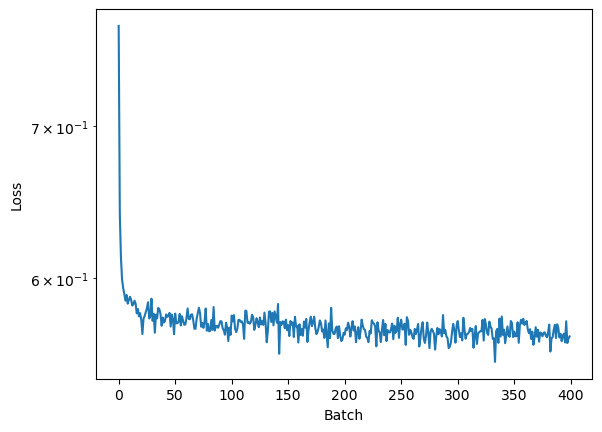

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

# set maximum y to 

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:02<00:40,  2.11s/it]

 10%|█         | 2/20 [00:04<00:40,  2.24s/it]

 15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]

 20%|██        | 4/20 [00:09<00:36,  2.29s/it]

 25%|██▌       | 5/20 [00:11<00:33,  2.27s/it]

 30%|███       | 6/20 [00:13<00:32,  2.31s/it]

 35%|███▌      | 7/20 [00:15<00:29,  2.25s/it]

 40%|████      | 8/20 [00:18<00:27,  2.27s/it]

 45%|████▌     | 9/20 [00:20<00:25,  2.29s/it]

 50%|█████     | 10/20 [00:22<00:22,  2.23s/it]

 55%|█████▌    | 11/20 [00:24<00:19,  2.19s/it]

 60%|██████    | 12/20 [00:26<00:17,  2.16s/it]

 65%|██████▌   | 13/20 [00:28<00:15,  2.15s/it]

 70%|███████   | 14/20 [00:30<00:12,  2.11s/it]

 75%|███████▌  | 15/20 [00:32<00:10,  2.08s/it]

 80%|████████  | 16/20 [00:35<00:08,  2.08s/it]

 85%|████████▌ | 17/20 [00:36<00:06,  2.03s/it]

 90%|█████████ | 18/20 [00:38<00:04,  2.02s/it]

 95%|█████████▌| 19/20 [00:40<00:01,  1.99s/it]

100%|██████████| 20/20 [00:42<00:00,  1.95s/it]

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]

Test Loss: 0.5838


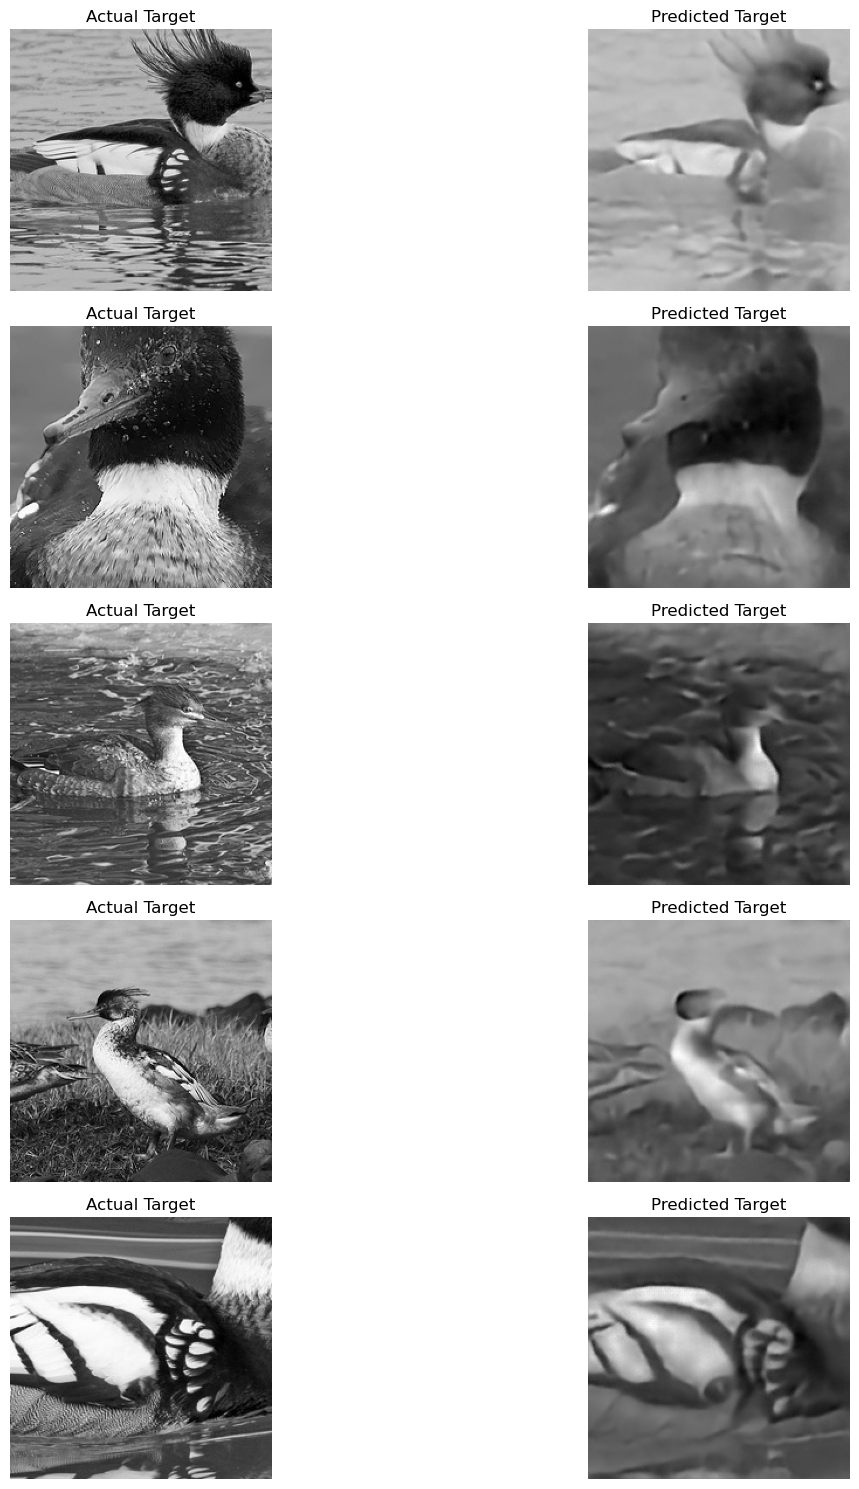

In [8]:

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-9.9220) tensor(7.1560)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
name = join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt")
torch.save(model, name)
print("Model saved to ", name)

Model saved to  /scratch/izar/vanousek/cs-433-project/models/mlp2497127.pt
